# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel works with user-defined LFs. Run every cell in the notebook (unless otherwise noted) before proceeding to the next one!
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import tensorflow as tf
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((dev_df, dev_labels), train_df, (test_df, test_labels)) = load_data()

**Input Data:** `dev_df` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below. We have other tutorials focused on generating such datasets (e.g., from richy-formatted data), but assume we have access to a Pandas DataFrame for the purpose of this specific tutorial!

In [2]:
dev_df.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, ..."
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton,..."
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue ...","[Prior, to, both, his, guests, ,, Colbert, s, ...","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, s..."
4,"(2, 2)","(4, 5)",People reported Williams and Ven Veen tied the...,"[People, reported, Williams, and, Ven, Veen, t...","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


You'll interact with these candidates while writing labeling functions in Snorkel. We look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = dev_df.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


# Part 2: Writing  Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse classification task below.

A labeling function is a Python function that accepts a candidate, or a row of the DataFrame, as the input argument and outputs a label for the candidate. For ease of exposition in this notebook, we return `1` if it says the pair of persons in the candidate were married at some point,  `-1` if the pair of persons in the candidate were never married, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are often unipolar: it labels only `1`s and `0`s, or it labels only `-1`s and `0`s.

(Note we will change our mapping to use `2` to represent the absence of a relationship to match the multiclass convention when feeding it to the LabelModel later.)
Recall that our goal is to ultimately train a high-performance classification model that predicts which of our candidates are true spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

#  I. Background

## Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

###  Using a _Development Set_ of Human-labeled Data

In our setting, we will use the phrase _development set_ to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions.  Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions. This is a list of `{-1,1}` labels.

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. Note that other domains and tasks, the required preprocessors will be different.

We provide several helper functions in `preprocessors`:  these are Python helper functions that you can apply to candidates in the DataFrame to return objects that are helpful during LF development. You can (and should!) write your own helper functions to help write LFs.

We provide an example of a preprocessor definition here:

In [4]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor()
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

## Candidate PreProcessors

We provide a set of helper functions for this task in `preprocessors.py` that take as input a candidate, or row of a DataFrame in our case. For the purpose of the tutorial, we have two of these fields preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_between_tokens(cand)`

`get_left_tokens(cand)`

`get_right_tokens(cand)`

II. Labeling Functions

# A. Pattern Matching Labeling Functions

One powerful form of labeling function design is defining sets of keywords or regular expressions that, as a human labeler, you know are correlated with the true label. For example, we could define a dictionary of terms that occur between person names in a candidate. One simple dictionary of terms indicating a true relation could be, which we could use in a labeling function like shown below:

    spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


    @labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
    def lf_husband_wife_left_window(x, spouses):
        if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
            return POSITIVE
        elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
            return POSITIVE
        else:
            return ABSTAIN

**Note that:**
1. To access the text between the person mentions, we can use the **`get_left_tokens` preprocessor!**
2. We use **resources like the spouses dictionary** to encode themes/categories of relationships!

There are a few advantages of having preprocessors and labeling functions in this form:

**Data Agnostic:**  Operate over multiple data types without rewriting

**Incremental Processing:** Can create preprocessors as needed while writing LFs!

**Future Use:** Can store them for later for different tasks since they are reproducible and modular

**Optimizations:** Allows caching behind-the-scenes

In [5]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(preprocessors=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the word `married` between person mentions
@labeling_function()
def lf_married(x):
    return POSITIVE if "married" in x.between_tokens else ABSTAIN

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = {
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
}
family = family.union({f + "-in-law" for f in family})


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), preprocessors=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [12]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
]
applier = PandasLFApplier(lfs)
L = applier.apply(dev_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  2%|▏         | 64/2811 [00:00<00:04, 634.94it/s]

  5%|▍         | 129/2811 [00:00<00:04, 638.50it/s]

  7%|▋         | 193/2811 [00:00<00:04, 636.11it/s]

  9%|▉         | 256/2811 [00:00<00:04, 633.60it/s]

 11%|█▏        | 321/2811 [00:00<00:03, 637.51it/s]

 14%|█▎        | 383/2811 [00:00<00:03, 631.79it/s]

 16%|█▌        | 447/2811 [00:00<00:03, 633.61it/s]

 18%|█▊        | 512/2811 [00:00<00:03, 635.99it/s]

 20%|██        | 576/2811 [00:00<00:03, 636.98it/s]

 23%|██▎       | 642/2811 [00:01<00:03, 641.33it/s]

 25%|██▌       | 706/2811 [00:01<00:03, 640.26it/s]

 27%|██▋       | 771/2811 [00:01<00:03, 641.90it/s]

 30%|██▉       | 836/2811 [00:01<00:03, 641.70it/s]

 32%|███▏      | 900/2811 [00:01<00:02, 641.00it/s]

 34%|███▍      | 965/2811 [00:01<00:02, 642.05it/s]

 37%|███▋      | 1029/2811 [00:01<00:02, 639.61it/s]

 39%|███▉      | 1093/2811 [00:01<00:02, 637.29it/s]

 41%|████      | 1158/2811 [00:01<00:02, 639.92it/s]

 44%|████▎     | 1223/2811 [00:01<00:02, 640.34it/s]

 46%|████▌     | 1288/2811 [00:02<00:02, 640.48it/s]

 48%|████▊     | 1353/2811 [00:02<00:02, 642.83it/s]

 50%|█████     | 1418/2811 [00:02<00:02, 642.95it/s]

 53%|█████▎    | 1483/2811 [00:02<00:02, 643.20it/s]

 55%|█████▌    | 1548/2811 [00:02<00:01, 642.29it/s]

 57%|█████▋    | 1613/2811 [00:02<00:01, 640.21it/s]

 60%|█████▉    | 1678/2811 [00:02<00:01, 639.70it/s]

 62%|██████▏   | 1743/2811 [00:02<00:01, 640.06it/s]

 64%|██████▍   | 1808/2811 [00:02<00:01, 639.51it/s]

 67%|██████▋   | 1873/2811 [00:02<00:01, 640.92it/s]

 69%|██████▉   | 1938/2811 [00:03<00:01, 642.94it/s]

 71%|███████▏  | 2003/2811 [00:03<00:01, 641.12it/s]

 74%|███████▎  | 2068/2811 [00:03<00:01, 636.52it/s]

 76%|███████▌  | 2133/2811 [00:03<00:01, 638.36it/s]

 78%|███████▊  | 2198/2811 [00:03<00:00, 639.48it/s]

 81%|████████  | 2263/2811 [00:03<00:00, 640.58it/s]

 83%|████████▎ | 2328/2811 [00:03<00:00, 639.06it/s]

 85%|████████▌ | 2393/2811 [00:03<00:00, 639.98it/s]

 87%|████████▋ | 2458/2811 [00:03<00:00, 640.04it/s]

 90%|████████▉ | 2523/2811 [00:03<00:00, 638.62it/s]

 92%|█████████▏| 2588/2811 [00:04<00:00, 639.97it/s]

 94%|█████████▍| 2653/2811 [00:04<00:00, 640.79it/s]

 97%|█████████▋| 2718/2811 [00:04<00:00, 641.72it/s]

 99%|█████████▉| 2783/2811 [00:04<00:00, 641.22it/s]

100%|██████████| 2811/2811 [00:04<00:00, 639.43it/s]

### Labeling Function Metrics

We can use the lf_summary function to measure various coverage related metrics for LFs. If we have gold labeled data, we can also evaluate accuracy.

#### Polarity
The set of label values the LF can output when it doesn't abstain. It is common for each LF to have a single polarity.

#### Coverage
The fraction of candidates that is labeled by our LF.

#### Overlaps
The fraction of examples labeled by the LF that is also labeled by another LF.

#### Conflicts
The fraction of examples labeled by the LF that is given a different (non-abstain) label by another LF.

#### Correct
The number of correctly labeled examples on the gold labeled data.

#### Incorrect
The number of incorrectly labeled examples on the gold labeled data.

#### Empirical Accuracy
The fraction of correctly labeled examples on the gold data.

In [13]:
from snorkel.labeling.analysis import LFAnalysis

lf_names = [lf.name for lf in lfs]
LFAnalysis(L).lf_summary(dev_labels, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.036642,0.017432,93,159,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.021345,0.003557,30,41,0.422535
lf_same_last_name,2,[1],0.040555,0.016009,0.008538,19,95,0.166667
lf_married,3,[1],0.019210,0.006403,0.002490,22,32,0.407407
lf_familial_relationship,4,[0],0.115617,0.051583,0.025969,310,15,0.953846
lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154


## B. Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [14]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('James I', 'Violant of Hungary'),
 ('Lucy Alexander', 'Stewart Castledine'),
 ('E. Duke Vincent', 'Pamela Hensley'),
 ('Julian Delphiki II', 'Petra Arkanian'),
 ('Alan Keen', 'Ann Keen')]

In [15]:
@labeling_function(
    resources=dict(known_spouses=known_spouses), preprocessors=[get_person_text]
)
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    if (p1, p2) in known_spouses or (p2, p1) in known_spouses:
        return POSITIVE
    else:
        return ABSTAIN

In [16]:
from preprocessors import last_name

# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(
    resources=dict(last_names=last_names), preprocessors=[get_person_last_names]
)
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

Every time you write a new labeling function, add it to appliers and make sure to include it in the new L matrix!

In [17]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [18]:
dev_L = applier.apply(dev_df)

train_L = applier.apply(train_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 38/2811 [00:00<00:07, 378.63it/s]

  3%|▎         | 76/2811 [00:00<00:07, 377.58it/s]

  4%|▍         | 114/2811 [00:00<00:07, 378.23it/s]

  5%|▌         | 152/2811 [00:00<00:07, 377.55it/s]

  7%|▋         | 190/2811 [00:00<00:06, 376.16it/s]

  8%|▊         | 227/2811 [00:00<00:06, 373.97it/s]

  9%|▉         | 265/2811 [00:00<00:06, 374.92it/s]

 11%|█         | 303/2811 [00:00<00:06, 375.63it/s]

 12%|█▏        | 340/2811 [00:00<00:06, 371.90it/s]

 13%|█▎        | 378/2811 [00:01<00:06, 371.55it/s]

 15%|█▍        | 415/2811 [00:01<00:06, 369.64it/s]

 16%|█▌        | 454/2811 [00:01<00:06, 373.21it/s]

 18%|█▊        | 492/2811 [00:01<00:06, 374.51it/s]

 19%|█▉        | 530/2811 [00:01<00:06, 375.47it/s]

 20%|██        | 568/2811 [00:01<00:05, 375.22it/s]

 22%|██▏       | 607/2811 [00:01<00:05, 377.22it/s]

 23%|██▎       | 646/2811 [00:01<00:05, 378.66it/s]

 24%|██▍       | 684/2811 [00:01<00:05, 377.47it/s]

 26%|██▌       | 723/2811 [00:01<00:05, 378.39it/s]

 27%|██▋       | 762/2811 [00:02<00:05, 379.43it/s]

 28%|██▊       | 800/2811 [00:02<00:05, 378.41it/s]

 30%|██▉       | 839/2811 [00:02<00:05, 379.08it/s]

 31%|███       | 877/2811 [00:02<00:05, 377.93it/s]

 33%|███▎      | 916/2811 [00:02<00:05, 378.96it/s]

 34%|███▍      | 955/2811 [00:02<00:04, 379.71it/s]

 35%|███▌      | 993/2811 [00:02<00:04, 378.77it/s]

 37%|███▋      | 1031/2811 [00:02<00:04, 377.01it/s]

 38%|███▊      | 1069/2811 [00:02<00:04, 377.22it/s]

 39%|███▉      | 1107/2811 [00:02<00:04, 376.39it/s]

 41%|████      | 1145/2811 [00:03<00:04, 376.94it/s]

 42%|████▏     | 1183/2811 [00:03<00:04, 377.77it/s]

 43%|████▎     | 1221/2811 [00:03<00:04, 377.38it/s]

 45%|████▍     | 1259/2811 [00:03<00:04, 377.32it/s]

 46%|████▌     | 1297/2811 [00:03<00:04, 376.80it/s]

 48%|████▊     | 1336/2811 [00:03<00:03, 378.38it/s]

 49%|████▉     | 1375/2811 [00:03<00:03, 379.69it/s]

 50%|█████     | 1414/2811 [00:03<00:03, 379.94it/s]

 52%|█████▏    | 1453/2811 [00:03<00:03, 380.46it/s]

 53%|█████▎    | 1492/2811 [00:03<00:03, 379.21it/s]

 54%|█████▍    | 1530/2811 [00:04<00:03, 379.01it/s]

 56%|█████▌    | 1569/2811 [00:04<00:03, 379.72it/s]

 57%|█████▋    | 1607/2811 [00:04<00:03, 378.78it/s]

 59%|█████▊    | 1645/2811 [00:04<00:03, 378.70it/s]

 60%|█████▉    | 1684/2811 [00:04<00:02, 379.37it/s]

 61%|██████▏   | 1722/2811 [00:04<00:02, 378.34it/s]

 63%|██████▎   | 1760/2811 [00:04<00:02, 378.77it/s]

 64%|██████▍   | 1798/2811 [00:04<00:02, 378.09it/s]

 65%|██████▌   | 1836/2811 [00:04<00:02, 376.61it/s]

 67%|██████▋   | 1875/2811 [00:04<00:02, 378.48it/s]

 68%|██████▊   | 1914/2811 [00:05<00:02, 379.25it/s]

 69%|██████▉   | 1953/2811 [00:05<00:02, 380.79it/s]

 71%|███████   | 1992/2811 [00:05<00:02, 378.78it/s]

 72%|███████▏  | 2030/2811 [00:05<00:02, 375.71it/s]

 74%|███████▎  | 2068/2811 [00:05<00:01, 372.40it/s]

 75%|███████▍  | 2106/2811 [00:05<00:01, 374.18it/s]

 76%|███████▋  | 2144/2811 [00:05<00:01, 375.25it/s]

 78%|███████▊  | 2182/2811 [00:05<00:01, 375.28it/s]

 79%|███████▉  | 2220/2811 [00:05<00:01, 376.02it/s]

 80%|████████  | 2259/2811 [00:05<00:01, 377.76it/s]

 82%|████████▏ | 2297/2811 [00:06<00:01, 377.19it/s]

 83%|████████▎ | 2335/2811 [00:06<00:01, 377.84it/s]

 84%|████████▍ | 2374/2811 [00:06<00:01, 379.32it/s]

 86%|████████▌ | 2412/2811 [00:06<00:01, 379.31it/s]

 87%|████████▋ | 2450/2811 [00:06<00:00, 379.20it/s]

 89%|████████▊ | 2489/2811 [00:06<00:00, 380.26it/s]

 90%|████████▉ | 2528/2811 [00:06<00:00, 380.06it/s]

 91%|█████████▏| 2567/2811 [00:06<00:00, 380.80it/s]

 93%|█████████▎| 2606/2811 [00:06<00:00, 380.35it/s]

 94%|█████████▍| 2645/2811 [00:07<00:00, 380.81it/s]

 95%|█████████▌| 2684/2811 [00:07<00:00, 379.78it/s]

 97%|█████████▋| 2723/2811 [00:07<00:00, 379.83it/s]

 98%|█████████▊| 2761/2811 [00:07<00:00, 379.20it/s]

100%|█████████▉| 2799/2811 [00:07<00:00, 378.91it/s]

100%|██████████| 2811/2811 [00:07<00:00, 377.47it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 36/22254 [00:00<01:02, 355.14it/s]

  0%|          | 74/22254 [00:00<01:01, 360.98it/s]

  1%|          | 112/22254 [00:00<01:00, 365.18it/s]

  1%|          | 150/22254 [00:00<01:00, 367.20it/s]

  1%|          | 188/22254 [00:00<00:59, 369.27it/s]

  1%|          | 226/22254 [00:00<00:59, 372.40it/s]

  1%|          | 265/22254 [00:00<00:58, 374.88it/s]

  1%|▏         | 303/22254 [00:00<00:58, 375.59it/s]

  2%|▏         | 341/22254 [00:00<00:58, 376.52it/s]

  2%|▏         | 378/22254 [00:01<00:58, 374.20it/s]

  2%|▏         | 416/22254 [00:01<00:58, 374.15it/s]

  2%|▏         | 454/22254 [00:01<00:58, 374.92it/s]

  2%|▏         | 492/22254 [00:01<00:57, 375.96it/s]

  2%|▏         | 530/22254 [00:01<00:58, 372.85it/s]

  3%|▎         | 568/22254 [00:01<00:58, 369.74it/s]

  3%|▎         | 606/22254 [00:01<00:58, 371.96it/s]

  3%|▎         | 644/22254 [00:01<00:57, 372.77it/s]

  3%|▎         | 682/22254 [00:01<00:58, 371.09it/s]

  3%|▎         | 721/22254 [00:01<00:57, 374.03it/s]

  3%|▎         | 759/22254 [00:02<00:57, 375.59it/s]

  4%|▎         | 797/22254 [00:02<00:57, 375.17it/s]

  4%|▍         | 835/22254 [00:02<00:56, 376.34it/s]

  4%|▍         | 873/22254 [00:02<00:56, 376.30it/s]

  4%|▍         | 912/22254 [00:02<00:56, 377.72it/s]

  4%|▍         | 951/22254 [00:02<00:56, 378.72it/s]

  4%|▍         | 989/22254 [00:02<00:56, 378.76it/s]

  5%|▍         | 1027/22254 [00:02<00:56, 377.18it/s]

  5%|▍         | 1065/22254 [00:02<00:56, 376.87it/s]

  5%|▍         | 1103/22254 [00:02<00:55, 377.72it/s]

  5%|▌         | 1141/22254 [00:03<00:56, 375.59it/s]

  5%|▌         | 1180/22254 [00:03<00:55, 376.97it/s]

  5%|▌         | 1218/22254 [00:03<00:55, 376.24it/s]

  6%|▌         | 1257/22254 [00:03<00:55, 377.75it/s]

  6%|▌         | 1296/22254 [00:03<00:55, 379.33it/s]

  6%|▌         | 1334/22254 [00:03<00:55, 378.50it/s]

  6%|▌         | 1372/22254 [00:03<00:55, 378.65it/s]

  6%|▋         | 1410/22254 [00:03<00:56, 372.21it/s]

  7%|▋         | 1448/22254 [00:03<00:55, 374.43it/s]

  7%|▋         | 1486/22254 [00:03<00:55, 373.07it/s]

  7%|▋         | 1524/22254 [00:04<00:55, 374.55it/s]

  7%|▋         | 1562/22254 [00:04<00:55, 374.69it/s]

  7%|▋         | 1600/22254 [00:04<00:55, 372.82it/s]

  7%|▋         | 1638/22254 [00:04<00:55, 374.21it/s]

  8%|▊         | 1676/22254 [00:04<00:55, 372.82it/s]

  8%|▊         | 1714/22254 [00:04<00:54, 373.63it/s]

  8%|▊         | 1752/22254 [00:04<00:54, 373.36it/s]

  8%|▊         | 1790/22254 [00:04<00:54, 374.08it/s]

  8%|▊         | 1828/22254 [00:04<00:54, 375.58it/s]

  8%|▊         | 1867/22254 [00:04<00:54, 376.99it/s]

  9%|▊         | 1905/22254 [00:05<00:54, 374.24it/s]

  9%|▊         | 1943/22254 [00:05<00:55, 367.06it/s]

  9%|▉         | 1981/22254 [00:05<00:54, 369.74it/s]

  9%|▉         | 2019/22254 [00:05<00:54, 371.97it/s]

  9%|▉         | 2057/22254 [00:05<00:54, 373.47it/s]

  9%|▉         | 2095/22254 [00:05<00:53, 374.95it/s]

 10%|▉         | 2133/22254 [00:05<00:53, 374.18it/s]

 10%|▉         | 2171/22254 [00:05<00:53, 373.47it/s]

 10%|▉         | 2209/22254 [00:05<00:53, 372.24it/s]

 10%|█         | 2248/22254 [00:06<00:53, 374.65it/s]

 10%|█         | 2286/22254 [00:06<00:53, 376.18it/s]

 10%|█         | 2324/22254 [00:06<00:53, 375.51it/s]

 11%|█         | 2362/22254 [00:06<00:53, 374.23it/s]

 11%|█         | 2400/22254 [00:06<00:53, 374.22it/s]

 11%|█         | 2438/22254 [00:06<00:53, 372.54it/s]

 11%|█         | 2476/22254 [00:06<00:52, 373.74it/s]

 11%|█▏        | 2514/22254 [00:06<00:52, 374.51it/s]

 11%|█▏        | 2552/22254 [00:06<00:52, 372.44it/s]

 12%|█▏        | 2590/22254 [00:06<00:52, 372.55it/s]

 12%|█▏        | 2628/22254 [00:07<00:52, 372.11it/s]

 12%|█▏        | 2666/22254 [00:07<00:53, 368.66it/s]

 12%|█▏        | 2704/22254 [00:07<00:52, 369.87it/s]

 12%|█▏        | 2742/22254 [00:07<00:52, 372.28it/s]

 12%|█▏        | 2780/22254 [00:07<00:52, 371.35it/s]

 13%|█▎        | 2818/22254 [00:07<00:52, 371.54it/s]

 13%|█▎        | 2856/22254 [00:07<00:52, 371.74it/s]

 13%|█▎        | 2894/22254 [00:07<00:51, 373.17it/s]

 13%|█▎        | 2932/22254 [00:07<00:51, 374.56it/s]

 13%|█▎        | 2970/22254 [00:07<00:51, 375.33it/s]

 14%|█▎        | 3008/22254 [00:08<00:51, 375.72it/s]

 14%|█▎        | 3046/22254 [00:08<00:51, 374.79it/s]

 14%|█▍        | 3084/22254 [00:08<00:51, 375.09it/s]

 14%|█▍        | 3122/22254 [00:08<00:50, 375.98it/s]

 14%|█▍        | 3160/22254 [00:08<00:50, 374.46it/s]

 14%|█▍        | 3198/22254 [00:08<00:51, 373.43it/s]

 15%|█▍        | 3236/22254 [00:08<00:50, 374.74it/s]

 15%|█▍        | 3274/22254 [00:08<00:50, 375.16it/s]

 15%|█▍        | 3312/22254 [00:08<00:50, 375.59it/s]

 15%|█▌        | 3350/22254 [00:08<00:50, 376.19it/s]

 15%|█▌        | 3388/22254 [00:09<00:50, 374.80it/s]

 15%|█▌        | 3426/22254 [00:09<00:50, 374.64it/s]

 16%|█▌        | 3464/22254 [00:09<00:50, 374.25it/s]

 16%|█▌        | 3502/22254 [00:09<00:50, 372.99it/s]

 16%|█▌        | 3540/22254 [00:09<00:50, 372.36it/s]

 16%|█▌        | 3578/22254 [00:09<00:50, 372.46it/s]

 16%|█▌        | 3616/22254 [00:09<00:49, 372.79it/s]

 16%|█▋        | 3654/22254 [00:09<00:49, 373.22it/s]

 17%|█▋        | 3692/22254 [00:09<00:49, 374.13it/s]

 17%|█▋        | 3730/22254 [00:09<00:49, 373.97it/s]

 17%|█▋        | 3768/22254 [00:10<00:49, 372.48it/s]

 17%|█▋        | 3806/22254 [00:10<00:49, 372.04it/s]

 17%|█▋        | 3844/22254 [00:10<00:49, 373.46it/s]

 17%|█▋        | 3882/22254 [00:10<00:49, 373.68it/s]

 18%|█▊        | 3920/22254 [00:10<00:48, 375.10it/s]

 18%|█▊        | 3958/22254 [00:10<00:48, 375.53it/s]

 18%|█▊        | 3996/22254 [00:10<00:48, 375.96it/s]

 18%|█▊        | 4034/22254 [00:10<00:48, 373.58it/s]

 18%|█▊        | 4072/22254 [00:10<00:48, 374.90it/s]

 18%|█▊        | 4110/22254 [00:10<00:48, 374.95it/s]

 19%|█▊        | 4148/22254 [00:11<00:48, 373.22it/s]

 19%|█▉        | 4186/22254 [00:11<00:48, 372.89it/s]

 19%|█▉        | 4224/22254 [00:11<00:48, 373.42it/s]

 19%|█▉        | 4262/22254 [00:11<00:48, 371.85it/s]

 19%|█▉        | 4300/22254 [00:11<00:48, 372.83it/s]

 19%|█▉        | 4338/22254 [00:11<00:48, 371.46it/s]

 20%|█▉        | 4376/22254 [00:11<00:48, 371.55it/s]

 20%|█▉        | 4414/22254 [00:11<00:48, 371.63it/s]

 20%|██        | 4452/22254 [00:11<00:47, 372.90it/s]

 20%|██        | 4490/22254 [00:12<00:47, 372.91it/s]

 20%|██        | 4528/22254 [00:12<00:47, 374.49it/s]

 21%|██        | 4566/22254 [00:12<00:47, 375.65it/s]

 21%|██        | 4604/22254 [00:12<00:46, 375.82it/s]

 21%|██        | 4642/22254 [00:12<00:46, 375.16it/s]

 21%|██        | 4680/22254 [00:12<00:46, 374.30it/s]

 21%|██        | 4718/22254 [00:12<00:46, 373.26it/s]

 21%|██▏       | 4756/22254 [00:12<00:47, 367.97it/s]

 22%|██▏       | 4793/22254 [00:12<00:47, 366.52it/s]

 22%|██▏       | 4832/22254 [00:12<00:46, 370.74it/s]

 22%|██▏       | 4870/22254 [00:13<00:46, 370.09it/s]

 22%|██▏       | 4908/22254 [00:13<00:46, 371.62it/s]

 22%|██▏       | 4947/22254 [00:13<00:46, 374.46it/s]

 22%|██▏       | 4985/22254 [00:13<00:46, 375.39it/s]

 23%|██▎       | 5023/22254 [00:13<00:45, 376.36it/s]

 23%|██▎       | 5061/22254 [00:13<00:45, 376.59it/s]

 23%|██▎       | 5099/22254 [00:13<00:45, 374.40it/s]

 23%|██▎       | 5137/22254 [00:13<00:45, 374.39it/s]

 23%|██▎       | 5175/22254 [00:13<00:45, 375.56it/s]

 23%|██▎       | 5213/22254 [00:13<00:45, 374.49it/s]

 24%|██▎       | 5251/22254 [00:14<00:45, 375.36it/s]

 24%|██▍       | 5289/22254 [00:14<00:45, 375.40it/s]

 24%|██▍       | 5328/22254 [00:14<00:44, 377.33it/s]

 24%|██▍       | 5366/22254 [00:14<00:44, 377.26it/s]

 24%|██▍       | 5404/22254 [00:14<00:44, 377.94it/s]

 24%|██▍       | 5442/22254 [00:14<00:44, 377.29it/s]

 25%|██▍       | 5480/22254 [00:14<00:44, 377.72it/s]

 25%|██▍       | 5519/22254 [00:14<00:44, 378.99it/s]

 25%|██▍       | 5558/22254 [00:14<00:43, 379.58it/s]

 25%|██▌       | 5596/22254 [00:14<00:44, 377.86it/s]

 25%|██▌       | 5634/22254 [00:15<00:44, 377.38it/s]

 25%|██▌       | 5672/22254 [00:15<00:43, 377.74it/s]

 26%|██▌       | 5710/22254 [00:15<00:43, 377.63it/s]

 26%|██▌       | 5748/22254 [00:15<00:43, 378.32it/s]

 26%|██▌       | 5786/22254 [00:15<00:43, 378.64it/s]

 26%|██▌       | 5824/22254 [00:15<00:43, 378.44it/s]

 26%|██▋       | 5862/22254 [00:15<00:43, 378.48it/s]

 27%|██▋       | 5900/22254 [00:15<00:43, 378.44it/s]

 27%|██▋       | 5938/22254 [00:15<00:43, 376.12it/s]

 27%|██▋       | 5976/22254 [00:15<00:43, 376.04it/s]

 27%|██▋       | 6014/22254 [00:16<00:43, 375.02it/s]

 27%|██▋       | 6052/22254 [00:16<00:43, 374.76it/s]

 27%|██▋       | 6090/22254 [00:16<00:43, 374.74it/s]

 28%|██▊       | 6128/22254 [00:16<00:43, 373.63it/s]

 28%|██▊       | 6166/22254 [00:16<00:43, 370.93it/s]

 28%|██▊       | 6204/22254 [00:16<00:43, 370.64it/s]

 28%|██▊       | 6242/22254 [00:16<00:43, 370.53it/s]

 28%|██▊       | 6280/22254 [00:16<00:42, 372.05it/s]

 28%|██▊       | 6318/22254 [00:16<00:42, 374.02it/s]

 29%|██▊       | 6356/22254 [00:16<00:42, 375.41it/s]

 29%|██▊       | 6394/22254 [00:17<00:42, 375.33it/s]

 29%|██▉       | 6432/22254 [00:17<00:42, 375.24it/s]

 29%|██▉       | 6470/22254 [00:17<00:42, 375.45it/s]

 29%|██▉       | 6508/22254 [00:17<00:42, 374.40it/s]

 29%|██▉       | 6546/22254 [00:17<00:41, 375.22it/s]

 30%|██▉       | 6584/22254 [00:17<00:41, 376.16it/s]

 30%|██▉       | 6622/22254 [00:17<00:41, 376.57it/s]

 30%|██▉       | 6660/22254 [00:17<00:41, 375.26it/s]

 30%|███       | 6698/22254 [00:17<00:41, 375.54it/s]

 30%|███       | 6736/22254 [00:17<00:41, 375.55it/s]

 30%|███       | 6774/22254 [00:18<00:41, 375.66it/s]

 31%|███       | 6812/22254 [00:18<00:41, 376.22it/s]

 31%|███       | 6850/22254 [00:18<00:40, 375.72it/s]

 31%|███       | 6888/22254 [00:18<00:40, 376.62it/s]

 31%|███       | 6926/22254 [00:18<00:40, 376.61it/s]

 31%|███▏      | 6965/22254 [00:18<00:40, 377.71it/s]

 31%|███▏      | 7003/22254 [00:18<00:41, 370.04it/s]

 32%|███▏      | 7041/22254 [00:18<00:40, 372.28it/s]

 32%|███▏      | 7079/22254 [00:18<00:40, 373.49it/s]

 32%|███▏      | 7117/22254 [00:19<00:40, 372.88it/s]

 32%|███▏      | 7155/22254 [00:19<00:40, 374.08it/s]

 32%|███▏      | 7193/22254 [00:19<00:40, 374.34it/s]

 32%|███▏      | 7231/22254 [00:19<00:39, 375.83it/s]

 33%|███▎      | 7269/22254 [00:19<00:39, 375.04it/s]

 33%|███▎      | 7307/22254 [00:19<00:39, 375.82it/s]

 33%|███▎      | 7345/22254 [00:19<00:39, 375.14it/s]

 33%|███▎      | 7383/22254 [00:19<00:39, 376.51it/s]

 33%|███▎      | 7421/22254 [00:19<00:39, 375.24it/s]

 34%|███▎      | 7459/22254 [00:19<00:39, 374.24it/s]

 34%|███▎      | 7497/22254 [00:20<00:39, 374.35it/s]

 34%|███▍      | 7535/22254 [00:20<00:39, 375.22it/s]

 34%|███▍      | 7573/22254 [00:20<00:39, 376.31it/s]

 34%|███▍      | 7611/22254 [00:20<00:38, 376.86it/s]

 34%|███▍      | 7650/22254 [00:20<00:38, 377.71it/s]

 35%|███▍      | 7688/22254 [00:20<00:38, 376.78it/s]

 35%|███▍      | 7726/22254 [00:20<00:38, 377.48it/s]

 35%|███▍      | 7764/22254 [00:20<00:38, 376.73it/s]

 35%|███▌      | 7803/22254 [00:20<00:38, 377.88it/s]

 35%|███▌      | 7841/22254 [00:20<00:38, 376.57it/s]

 35%|███▌      | 7879/22254 [00:21<00:38, 377.03it/s]

 36%|███▌      | 7917/22254 [00:21<00:38, 375.13it/s]

 36%|███▌      | 7955/22254 [00:21<00:38, 373.74it/s]

 36%|███▌      | 7993/22254 [00:21<00:38, 369.30it/s]

 36%|███▌      | 8031/22254 [00:21<00:38, 372.02it/s]

 36%|███▋      | 8069/22254 [00:21<00:38, 372.99it/s]

 36%|███▋      | 8108/22254 [00:21<00:37, 375.37it/s]

 37%|███▋      | 8146/22254 [00:21<00:37, 373.46it/s]

 37%|███▋      | 8184/22254 [00:21<00:37, 373.57it/s]

 37%|███▋      | 8222/22254 [00:21<00:37, 372.66it/s]

 37%|███▋      | 8260/22254 [00:22<00:37, 374.26it/s]

 37%|███▋      | 8298/22254 [00:22<00:37, 375.35it/s]

 37%|███▋      | 8336/22254 [00:22<00:37, 375.40it/s]

 38%|███▊      | 8374/22254 [00:22<00:37, 374.36it/s]

 38%|███▊      | 8412/22254 [00:22<00:36, 375.11it/s]

 38%|███▊      | 8450/22254 [00:22<00:36, 376.24it/s]

 38%|███▊      | 8488/22254 [00:22<00:36, 377.31it/s]

 38%|███▊      | 8526/22254 [00:22<00:36, 376.36it/s]

 38%|███▊      | 8565/22254 [00:22<00:36, 378.11it/s]

 39%|███▊      | 8603/22254 [00:22<00:36, 376.99it/s]

 39%|███▉      | 8641/22254 [00:23<00:36, 376.95it/s]

 39%|███▉      | 8679/22254 [00:23<00:36, 376.19it/s]

 39%|███▉      | 8717/22254 [00:23<00:36, 374.80it/s]

 39%|███▉      | 8755/22254 [00:23<00:35, 375.75it/s]

 40%|███▉      | 8793/22254 [00:23<00:35, 376.62it/s]

 40%|███▉      | 8832/22254 [00:23<00:35, 377.91it/s]

 40%|███▉      | 8870/22254 [00:23<00:35, 375.88it/s]

 40%|████      | 8908/22254 [00:23<00:35, 372.23it/s]

 40%|████      | 8946/22254 [00:23<00:35, 370.19it/s]

 40%|████      | 8984/22254 [00:23<00:36, 367.08it/s]

 41%|████      | 9022/22254 [00:24<00:35, 368.77it/s]

 41%|████      | 9060/22254 [00:24<00:35, 369.92it/s]

 41%|████      | 9098/22254 [00:24<00:35, 372.17it/s]

 41%|████      | 9136/22254 [00:24<00:35, 372.01it/s]

 41%|████      | 9174/22254 [00:24<00:35, 372.64it/s]

 41%|████▏     | 9212/22254 [00:24<00:35, 372.34it/s]

 42%|████▏     | 9250/22254 [00:24<00:35, 368.67it/s]

 42%|████▏     | 9288/22254 [00:24<00:34, 370.74it/s]

 42%|████▏     | 9326/22254 [00:24<00:34, 372.76it/s]

 42%|████▏     | 9364/22254 [00:25<00:34, 373.99it/s]

 42%|████▏     | 9402/22254 [00:25<00:34, 374.62it/s]

 42%|████▏     | 9440/22254 [00:25<00:34, 374.63it/s]

 43%|████▎     | 9478/22254 [00:25<00:34, 374.63it/s]

 43%|████▎     | 9516/22254 [00:25<00:33, 375.61it/s]

 43%|████▎     | 9554/22254 [00:25<00:33, 373.93it/s]

 43%|████▎     | 9593/22254 [00:25<00:33, 376.06it/s]

 43%|████▎     | 9631/22254 [00:25<00:33, 377.08it/s]

 43%|████▎     | 9670/22254 [00:25<00:33, 378.04it/s]

 44%|████▎     | 9708/22254 [00:25<00:33, 378.59it/s]

 44%|████▍     | 9746/22254 [00:26<00:33, 377.49it/s]

 44%|████▍     | 9784/22254 [00:26<00:32, 377.93it/s]

 44%|████▍     | 9822/22254 [00:26<00:32, 377.51it/s]

 44%|████▍     | 9860/22254 [00:26<00:32, 377.99it/s]

 44%|████▍     | 9899/22254 [00:26<00:32, 378.70it/s]

 45%|████▍     | 9937/22254 [00:26<00:32, 378.36it/s]

 45%|████▍     | 9975/22254 [00:26<00:32, 377.21it/s]

 45%|████▍     | 10013/22254 [00:26<00:32, 376.82it/s]

 45%|████▌     | 10051/22254 [00:26<00:32, 376.23it/s]

 45%|████▌     | 10089/22254 [00:26<00:32, 375.50it/s]

 46%|████▌     | 10127/22254 [00:27<00:32, 374.97it/s]

 46%|████▌     | 10165/22254 [00:27<00:32, 375.83it/s]

 46%|████▌     | 10203/22254 [00:27<00:32, 374.86it/s]

 46%|████▌     | 10241/22254 [00:27<00:32, 373.82it/s]

 46%|████▌     | 10279/22254 [00:27<00:31, 375.20it/s]

 46%|████▋     | 10317/22254 [00:27<00:31, 375.29it/s]

 47%|████▋     | 10355/22254 [00:27<00:31, 374.17it/s]

 47%|████▋     | 10393/22254 [00:27<00:31, 373.07it/s]

 47%|████▋     | 10431/22254 [00:27<00:31, 374.21it/s]

 47%|████▋     | 10469/22254 [00:27<00:31, 375.91it/s]

 47%|████▋     | 10507/22254 [00:28<00:31, 377.05it/s]

 47%|████▋     | 10546/22254 [00:28<00:30, 378.39it/s]

 48%|████▊     | 10584/22254 [00:28<00:30, 378.36it/s]

 48%|████▊     | 10622/22254 [00:28<00:31, 375.11it/s]

 48%|████▊     | 10660/22254 [00:28<00:30, 375.44it/s]

 48%|████▊     | 10698/22254 [00:28<00:30, 375.62it/s]

 48%|████▊     | 10736/22254 [00:28<00:30, 374.19it/s]

 48%|████▊     | 10774/22254 [00:28<00:30, 373.27it/s]

 49%|████▊     | 10812/22254 [00:28<00:30, 372.42it/s]

 49%|████▉     | 10850/22254 [00:28<00:30, 374.63it/s]

 49%|████▉     | 10888/22254 [00:29<00:30, 374.94it/s]

 49%|████▉     | 10926/22254 [00:29<00:30, 374.50it/s]

 49%|████▉     | 10964/22254 [00:29<00:30, 374.15it/s]

 49%|████▉     | 11002/22254 [00:29<00:30, 374.50it/s]

 50%|████▉     | 11040/22254 [00:29<00:29, 375.11it/s]

 50%|████▉     | 11079/22254 [00:29<00:29, 376.73it/s]

 50%|████▉     | 11117/22254 [00:29<00:29, 375.71it/s]

 50%|█████     | 11155/22254 [00:29<00:29, 375.07it/s]

 50%|█████     | 11193/22254 [00:29<00:29, 374.91it/s]

 50%|█████     | 11231/22254 [00:29<00:29, 374.12it/s]

 51%|█████     | 11269/22254 [00:30<00:29, 373.57it/s]

 51%|█████     | 11307/22254 [00:30<00:29, 374.36it/s]

 51%|█████     | 11345/22254 [00:30<00:29, 371.76it/s]

 51%|█████     | 11384/22254 [00:30<00:29, 374.50it/s]

 51%|█████▏    | 11422/22254 [00:30<00:29, 372.82it/s]

 51%|█████▏    | 11460/22254 [00:30<00:28, 374.78it/s]

 52%|█████▏    | 11498/22254 [00:30<00:28, 374.45it/s]

 52%|█████▏    | 11536/22254 [00:30<00:28, 370.33it/s]

 52%|█████▏    | 11574/22254 [00:30<00:28, 370.58it/s]

 52%|█████▏    | 11612/22254 [00:31<00:28, 371.36it/s]

 52%|█████▏    | 11650/22254 [00:31<00:28, 372.02it/s]

 53%|█████▎    | 11688/22254 [00:31<00:28, 372.19it/s]

 53%|█████▎    | 11726/22254 [00:31<00:28, 372.68it/s]

 53%|█████▎    | 11764/22254 [00:31<00:28, 373.35it/s]

 53%|█████▎    | 11802/22254 [00:31<00:27, 373.68it/s]

 53%|█████▎    | 11840/22254 [00:31<00:27, 372.69it/s]

 53%|█████▎    | 11878/22254 [00:31<00:27, 373.89it/s]

 54%|█████▎    | 11916/22254 [00:31<00:27, 371.50it/s]

 54%|█████▎    | 11954/22254 [00:31<00:27, 371.88it/s]

 54%|█████▍    | 11992/22254 [00:32<00:28, 364.84it/s]

 54%|█████▍    | 12029/22254 [00:32<00:29, 345.02it/s]

 54%|█████▍    | 12064/22254 [00:32<00:31, 320.47it/s]

 54%|█████▍    | 12102/22254 [00:32<00:30, 335.25it/s]

 55%|█████▍    | 12140/22254 [00:32<00:29, 345.37it/s]

 55%|█████▍    | 12178/22254 [00:32<00:28, 353.50it/s]

 55%|█████▍    | 12216/22254 [00:32<00:27, 359.19it/s]

 55%|█████▌    | 12254/22254 [00:32<00:27, 363.90it/s]

 55%|█████▌    | 12292/22254 [00:32<00:27, 367.69it/s]

 55%|█████▌    | 12331/22254 [00:32<00:26, 371.44it/s]

 56%|█████▌    | 12369/22254 [00:33<00:26, 372.28it/s]

 56%|█████▌    | 12407/22254 [00:33<00:26, 373.60it/s]

 56%|█████▌    | 12446/22254 [00:33<00:26, 375.67it/s]

 56%|█████▌    | 12484/22254 [00:33<00:25, 375.90it/s]

 56%|█████▋    | 12522/22254 [00:33<00:25, 375.80it/s]

 56%|█████▋    | 12560/22254 [00:33<00:25, 376.37it/s]

 57%|█████▋    | 12598/22254 [00:33<00:25, 376.59it/s]

 57%|█████▋    | 12636/22254 [00:33<00:25, 375.39it/s]

 57%|█████▋    | 12674/22254 [00:33<00:25, 376.11it/s]

 57%|█████▋    | 12712/22254 [00:33<00:25, 375.92it/s]

 57%|█████▋    | 12750/22254 [00:34<00:25, 375.98it/s]

 57%|█████▋    | 12788/22254 [00:34<00:25, 375.03it/s]

 58%|█████▊    | 12826/22254 [00:34<00:25, 376.26it/s]

 58%|█████▊    | 12864/22254 [00:34<00:24, 376.02it/s]

 58%|█████▊    | 12902/22254 [00:34<00:24, 376.28it/s]

 58%|█████▊    | 12940/22254 [00:34<00:24, 376.50it/s]

 58%|█████▊    | 12978/22254 [00:34<00:24, 376.98it/s]

 58%|█████▊    | 13016/22254 [00:34<00:24, 376.96it/s]

 59%|█████▊    | 13054/22254 [00:34<00:24, 376.30it/s]

 59%|█████▉    | 13092/22254 [00:35<00:24, 376.54it/s]

 59%|█████▉    | 13130/22254 [00:35<00:24, 376.39it/s]

 59%|█████▉    | 13168/22254 [00:35<00:24, 375.82it/s]

 59%|█████▉    | 13206/22254 [00:35<00:24, 374.04it/s]

 60%|█████▉    | 13244/22254 [00:35<00:24, 374.58it/s]

 60%|█████▉    | 13282/22254 [00:35<00:24, 373.54it/s]

 60%|█████▉    | 13320/22254 [00:35<00:23, 375.38it/s]

 60%|██████    | 13358/22254 [00:35<00:23, 374.39it/s]

 60%|██████    | 13396/22254 [00:35<00:23, 369.20it/s]

 60%|██████    | 13434/22254 [00:35<00:23, 371.66it/s]

 61%|██████    | 13472/22254 [00:36<00:23, 374.05it/s]

 61%|██████    | 13510/22254 [00:36<00:23, 375.49it/s]

 61%|██████    | 13548/22254 [00:36<00:23, 375.21it/s]

 61%|██████    | 13586/22254 [00:36<00:23, 375.10it/s]

 61%|██████    | 13624/22254 [00:36<00:22, 376.16it/s]

 61%|██████▏   | 13663/22254 [00:36<00:22, 377.81it/s]

 62%|██████▏   | 13701/22254 [00:36<00:22, 377.67it/s]

 62%|██████▏   | 13739/22254 [00:36<00:22, 377.99it/s]

 62%|██████▏   | 13777/22254 [00:36<00:22, 375.15it/s]

 62%|██████▏   | 13815/22254 [00:36<00:22, 373.28it/s]

 62%|██████▏   | 13853/22254 [00:37<00:22, 375.23it/s]

 62%|██████▏   | 13891/22254 [00:37<00:22, 376.31it/s]

 63%|██████▎   | 13929/22254 [00:37<00:22, 376.89it/s]

 63%|██████▎   | 13967/22254 [00:37<00:21, 376.92it/s]

 63%|██████▎   | 14005/22254 [00:37<00:21, 376.28it/s]

 63%|██████▎   | 14043/22254 [00:37<00:21, 375.61it/s]

 63%|██████▎   | 14081/22254 [00:37<00:21, 375.57it/s]

 63%|██████▎   | 14119/22254 [00:37<00:21, 375.35it/s]

 64%|██████▎   | 14157/22254 [00:37<00:21, 375.25it/s]

 64%|██████▍   | 14195/22254 [00:37<00:21, 375.89it/s]

 64%|██████▍   | 14233/22254 [00:38<00:21, 376.37it/s]

 64%|██████▍   | 14271/22254 [00:38<00:21, 375.16it/s]

 64%|██████▍   | 14309/22254 [00:38<00:21, 375.87it/s]

 64%|██████▍   | 14347/22254 [00:38<00:21, 375.05it/s]

 65%|██████▍   | 14385/22254 [00:38<00:21, 374.35it/s]

 65%|██████▍   | 14423/22254 [00:38<00:20, 374.31it/s]

 65%|██████▍   | 14461/22254 [00:38<00:20, 373.38it/s]

 65%|██████▌   | 14499/22254 [00:38<00:20, 373.49it/s]

 65%|██████▌   | 14537/22254 [00:38<00:20, 374.66it/s]

 65%|██████▌   | 14575/22254 [00:38<00:20, 376.12it/s]

 66%|██████▌   | 14613/22254 [00:39<00:20, 374.51it/s]

 66%|██████▌   | 14652/22254 [00:39<00:20, 376.32it/s]

 66%|██████▌   | 14690/22254 [00:39<00:20, 376.63it/s]

 66%|██████▌   | 14728/22254 [00:39<00:19, 376.97it/s]

 66%|██████▋   | 14766/22254 [00:39<00:19, 377.33it/s]

 67%|██████▋   | 14804/22254 [00:39<00:19, 376.44it/s]

 67%|██████▋   | 14842/22254 [00:39<00:20, 362.04it/s]

 67%|██████▋   | 14879/22254 [00:39<00:20, 363.27it/s]

 67%|██████▋   | 14917/22254 [00:39<00:20, 366.58it/s]

 67%|██████▋   | 14955/22254 [00:39<00:19, 368.61it/s]

 67%|██████▋   | 14993/22254 [00:40<00:19, 370.55it/s]

 68%|██████▊   | 15031/22254 [00:40<00:19, 372.48it/s]

 68%|██████▊   | 15069/22254 [00:40<00:19, 374.46it/s]

 68%|██████▊   | 15107/22254 [00:40<00:19, 374.40it/s]

 68%|██████▊   | 15145/22254 [00:40<00:19, 373.81it/s]

 68%|██████▊   | 15183/22254 [00:40<00:18, 375.09it/s]

 68%|██████▊   | 15221/22254 [00:40<00:18, 374.64it/s]

 69%|██████▊   | 15259/22254 [00:40<00:18, 374.27it/s]

 69%|██████▊   | 15297/22254 [00:40<00:18, 374.62it/s]

 69%|██████▉   | 15335/22254 [00:41<00:18, 374.52it/s]

 69%|██████▉   | 15373/22254 [00:41<00:18, 374.75it/s]

 69%|██████▉   | 15411/22254 [00:41<00:18, 375.27it/s]

 69%|██████▉   | 15449/22254 [00:41<00:18, 375.87it/s]

 70%|██████▉   | 15487/22254 [00:41<00:18, 375.33it/s]

 70%|██████▉   | 15525/22254 [00:41<00:17, 375.48it/s]

 70%|██████▉   | 15563/22254 [00:41<00:17, 373.56it/s]

 70%|███████   | 15601/22254 [00:41<00:17, 373.58it/s]

 70%|███████   | 15639/22254 [00:41<00:17, 373.62it/s]

 70%|███████   | 15677/22254 [00:41<00:17, 372.67it/s]

 71%|███████   | 15715/22254 [00:42<00:17, 369.20it/s]

 71%|███████   | 15753/22254 [00:42<00:17, 370.30it/s]

 71%|███████   | 15791/22254 [00:42<00:17, 369.08it/s]

 71%|███████   | 15829/22254 [00:42<00:17, 371.45it/s]

 71%|███████▏  | 15867/22254 [00:42<00:17, 371.92it/s]

 71%|███████▏  | 15905/22254 [00:42<00:17, 373.40it/s]

 72%|███████▏  | 15943/22254 [00:42<00:16, 374.56it/s]

 72%|███████▏  | 15981/22254 [00:42<00:16, 375.08it/s]

 72%|███████▏  | 16019/22254 [00:42<00:16, 373.60it/s]

 72%|███████▏  | 16057/22254 [00:42<00:16, 372.70it/s]

 72%|███████▏  | 16095/22254 [00:43<00:16, 373.44it/s]

 72%|███████▏  | 16133/22254 [00:43<00:16, 371.27it/s]

 73%|███████▎  | 16171/22254 [00:43<00:16, 370.36it/s]

 73%|███████▎  | 16209/22254 [00:43<00:16, 371.11it/s]

 73%|███████▎  | 16247/22254 [00:43<00:16, 371.34it/s]

 73%|███████▎  | 16285/22254 [00:43<00:15, 373.08it/s]

 73%|███████▎  | 16323/22254 [00:43<00:15, 374.01it/s]

 74%|███████▎  | 16361/22254 [00:43<00:15, 374.64it/s]

 74%|███████▎  | 16399/22254 [00:43<00:15, 375.05it/s]

 74%|███████▍  | 16437/22254 [00:43<00:15, 375.36it/s]

 74%|███████▍  | 16475/22254 [00:44<00:15, 375.23it/s]

 74%|███████▍  | 16513/22254 [00:44<00:15, 375.35it/s]

 74%|███████▍  | 16551/22254 [00:44<00:15, 374.95it/s]

 75%|███████▍  | 16589/22254 [00:44<00:15, 373.11it/s]

 75%|███████▍  | 16627/22254 [00:44<00:15, 373.96it/s]

 75%|███████▍  | 16665/22254 [00:44<00:14, 374.94it/s]

 75%|███████▌  | 16703/22254 [00:44<00:14, 374.32it/s]

 75%|███████▌  | 16741/22254 [00:44<00:14, 375.75it/s]

 75%|███████▌  | 16779/22254 [00:44<00:14, 375.40it/s]

 76%|███████▌  | 16817/22254 [00:44<00:14, 376.57it/s]

 76%|███████▌  | 16856/22254 [00:45<00:14, 378.07it/s]

 76%|███████▌  | 16894/22254 [00:45<00:14, 371.75it/s]

 76%|███████▌  | 16932/22254 [00:45<00:14, 372.18it/s]

 76%|███████▋  | 16970/22254 [00:45<00:14, 374.07it/s]

 76%|███████▋  | 17008/22254 [00:45<00:14, 374.35it/s]

 77%|███████▋  | 17046/22254 [00:45<00:13, 374.61it/s]

 77%|███████▋  | 17084/22254 [00:45<00:13, 375.95it/s]

 77%|███████▋  | 17122/22254 [00:45<00:13, 376.32it/s]

 77%|███████▋  | 17160/22254 [00:45<00:13, 376.38it/s]

 77%|███████▋  | 17198/22254 [00:45<00:13, 373.17it/s]

 77%|███████▋  | 17236/22254 [00:46<00:13, 371.01it/s]

 78%|███████▊  | 17274/22254 [00:46<00:13, 370.36it/s]

 78%|███████▊  | 17312/22254 [00:46<00:13, 372.36it/s]

 78%|███████▊  | 17350/22254 [00:46<00:13, 374.59it/s]

 78%|███████▊  | 17388/22254 [00:46<00:13, 373.71it/s]

 78%|███████▊  | 17426/22254 [00:46<00:12, 372.96it/s]

 78%|███████▊  | 17464/22254 [00:46<00:12, 373.29it/s]

 79%|███████▊  | 17502/22254 [00:46<00:12, 371.41it/s]

 79%|███████▉  | 17541/22254 [00:46<00:12, 374.44it/s]

 79%|███████▉  | 17579/22254 [00:47<00:12, 375.96it/s]

 79%|███████▉  | 17617/22254 [00:47<00:12, 376.76it/s]

 79%|███████▉  | 17655/22254 [00:47<00:12, 376.87it/s]

 80%|███████▉  | 17693/22254 [00:47<00:12, 377.62it/s]

 80%|███████▉  | 17731/22254 [00:47<00:11, 377.64it/s]

 80%|███████▉  | 17769/22254 [00:47<00:11, 376.47it/s]

 80%|████████  | 17807/22254 [00:47<00:11, 376.38it/s]

 80%|████████  | 17846/22254 [00:47<00:11, 377.86it/s]

 80%|████████  | 17884/22254 [00:47<00:11, 377.38it/s]

 81%|████████  | 17922/22254 [00:47<00:11, 376.26it/s]

 81%|████████  | 17960/22254 [00:48<00:11, 374.36it/s]

 81%|████████  | 17998/22254 [00:48<00:11, 373.18it/s]

 81%|████████  | 18036/22254 [00:48<00:11, 374.70it/s]

 81%|████████  | 18075/22254 [00:48<00:11, 376.58it/s]

 81%|████████▏ | 18114/22254 [00:48<00:10, 377.86it/s]

 82%|████████▏ | 18152/22254 [00:48<00:10, 377.00it/s]

 82%|████████▏ | 18190/22254 [00:48<00:10, 375.06it/s]

 82%|████████▏ | 18228/22254 [00:48<00:10, 375.78it/s]

 82%|████████▏ | 18266/22254 [00:48<00:10, 376.04it/s]

 82%|████████▏ | 18305/22254 [00:48<00:10, 377.39it/s]

 82%|████████▏ | 18344/22254 [00:49<00:10, 378.45it/s]

 83%|████████▎ | 18382/22254 [00:49<00:10, 377.78it/s]

 83%|████████▎ | 18421/22254 [00:49<00:10, 378.99it/s]

 83%|████████▎ | 18460/22254 [00:49<00:09, 379.96it/s]

 83%|████████▎ | 18498/22254 [00:49<00:09, 377.83it/s]

 83%|████████▎ | 18536/22254 [00:49<00:09, 376.73it/s]

 83%|████████▎ | 18574/22254 [00:49<00:09, 375.85it/s]

 84%|████████▎ | 18612/22254 [00:49<00:09, 375.06it/s]

 84%|████████▍ | 18650/22254 [00:49<00:09, 374.17it/s]

 84%|████████▍ | 18688/22254 [00:49<00:09, 373.52it/s]

 84%|████████▍ | 18726/22254 [00:50<00:09, 373.23it/s]

 84%|████████▍ | 18764/22254 [00:50<00:09, 375.02it/s]

 84%|████████▍ | 18803/22254 [00:50<00:09, 376.63it/s]

 85%|████████▍ | 18841/22254 [00:50<00:09, 375.64it/s]

 85%|████████▍ | 18879/22254 [00:50<00:08, 375.79it/s]

 85%|████████▌ | 18917/22254 [00:50<00:08, 376.31it/s]

 85%|████████▌ | 18955/22254 [00:50<00:08, 377.30it/s]

 85%|████████▌ | 18993/22254 [00:50<00:08, 376.72it/s]

 86%|████████▌ | 19031/22254 [00:50<00:08, 376.99it/s]

 86%|████████▌ | 19070/22254 [00:50<00:08, 377.94it/s]

 86%|████████▌ | 19108/22254 [00:51<00:08, 376.41it/s]

 86%|████████▌ | 19146/22254 [00:51<00:08, 375.96it/s]

 86%|████████▌ | 19184/22254 [00:51<00:08, 375.70it/s]

 86%|████████▋ | 19222/22254 [00:51<00:08, 376.33it/s]

 87%|████████▋ | 19260/22254 [00:51<00:07, 376.72it/s]

 87%|████████▋ | 19298/22254 [00:51<00:07, 376.66it/s]

 87%|████████▋ | 19336/22254 [00:51<00:07, 374.91it/s]

 87%|████████▋ | 19374/22254 [00:51<00:07, 374.53it/s]

 87%|████████▋ | 19412/22254 [00:51<00:07, 374.43it/s]

 87%|████████▋ | 19451/22254 [00:51<00:07, 376.49it/s]

 88%|████████▊ | 19489/22254 [00:52<00:07, 375.39it/s]

 88%|████████▊ | 19527/22254 [00:52<00:07, 376.45it/s]

 88%|████████▊ | 19565/22254 [00:52<00:07, 374.69it/s]

 88%|████████▊ | 19604/22254 [00:52<00:07, 376.36it/s]

 88%|████████▊ | 19642/22254 [00:52<00:06, 376.64it/s]

 88%|████████▊ | 19680/22254 [00:52<00:06, 374.92it/s]

 89%|████████▊ | 19719/22254 [00:52<00:06, 376.83it/s]

 89%|████████▉ | 19757/22254 [00:52<00:06, 377.07it/s]

 89%|████████▉ | 19795/22254 [00:52<00:06, 376.77it/s]

 89%|████████▉ | 19833/22254 [00:52<00:06, 377.19it/s]

 89%|████████▉ | 19871/22254 [00:53<00:06, 375.48it/s]

 89%|████████▉ | 19909/22254 [00:53<00:06, 375.62it/s]

 90%|████████▉ | 19947/22254 [00:53<00:06, 376.64it/s]

 90%|████████▉ | 19985/22254 [00:53<00:06, 374.66it/s]

 90%|████████▉ | 20024/22254 [00:53<00:05, 376.30it/s]

 90%|█████████ | 20062/22254 [00:53<00:05, 376.30it/s]

 90%|█████████ | 20100/22254 [00:53<00:05, 375.36it/s]

 90%|█████████ | 20138/22254 [00:53<00:05, 375.60it/s]

 91%|█████████ | 20176/22254 [00:53<00:05, 375.93it/s]

 91%|█████████ | 20214/22254 [00:54<00:05, 375.37it/s]

 91%|█████████ | 20252/22254 [00:54<00:05, 375.51it/s]

 91%|█████████ | 20290/22254 [00:54<00:05, 376.75it/s]

 91%|█████████▏| 20328/22254 [00:54<00:05, 376.97it/s]

 92%|█████████▏| 20367/22254 [00:54<00:04, 378.11it/s]

 92%|█████████▏| 20405/22254 [00:54<00:04, 376.40it/s]

 92%|█████████▏| 20443/22254 [00:54<00:04, 374.99it/s]

 92%|█████████▏| 20481/22254 [00:54<00:04, 375.92it/s]

 92%|█████████▏| 20519/22254 [00:54<00:04, 375.97it/s]

 92%|█████████▏| 20557/22254 [00:54<00:04, 376.73it/s]

 93%|█████████▎| 20595/22254 [00:55<00:04, 376.22it/s]

 93%|█████████▎| 20633/22254 [00:55<00:04, 374.43it/s]

 93%|█████████▎| 20671/22254 [00:55<00:04, 375.52it/s]

 93%|█████████▎| 20709/22254 [00:55<00:04, 374.72it/s]

 93%|█████████▎| 20748/22254 [00:55<00:03, 376.84it/s]

 93%|█████████▎| 20786/22254 [00:55<00:03, 376.24it/s]

 94%|█████████▎| 20825/22254 [00:55<00:03, 377.96it/s]

 94%|█████████▎| 20863/22254 [00:55<00:03, 374.13it/s]

 94%|█████████▍| 20901/22254 [00:55<00:03, 375.46it/s]

 94%|█████████▍| 20940/22254 [00:55<00:03, 376.90it/s]

 94%|█████████▍| 20978/22254 [00:56<00:03, 375.65it/s]

 94%|█████████▍| 21016/22254 [00:56<00:03, 373.69it/s]

 95%|█████████▍| 21054/22254 [00:56<00:03, 374.66it/s]

 95%|█████████▍| 21092/22254 [00:56<00:03, 374.80it/s]

 95%|█████████▍| 21130/22254 [00:56<00:03, 374.37it/s]

 95%|█████████▌| 21168/22254 [00:56<00:02, 375.77it/s]

 95%|█████████▌| 21206/22254 [00:56<00:02, 374.92it/s]

 95%|█████████▌| 21244/22254 [00:56<00:02, 374.02it/s]

 96%|█████████▌| 21283/22254 [00:56<00:02, 375.99it/s]

 96%|█████████▌| 21321/22254 [00:56<00:02, 376.80it/s]

 96%|█████████▌| 21359/22254 [00:57<00:02, 376.51it/s]

 96%|█████████▌| 21397/22254 [00:57<00:02, 376.97it/s]

 96%|█████████▋| 21435/22254 [00:57<00:02, 377.63it/s]

 96%|█████████▋| 21473/22254 [00:57<00:02, 373.45it/s]

 97%|█████████▋| 21511/22254 [00:57<00:01, 373.72it/s]

 97%|█████████▋| 21549/22254 [00:57<00:01, 374.85it/s]

 97%|█████████▋| 21587/22254 [00:57<00:01, 374.43it/s]

 97%|█████████▋| 21625/22254 [00:57<00:01, 375.47it/s]

 97%|█████████▋| 21663/22254 [00:57<00:01, 375.95it/s]

 98%|█████████▊| 21701/22254 [00:57<00:01, 376.15it/s]

 98%|█████████▊| 21740/22254 [00:58<00:01, 377.11it/s]

 98%|█████████▊| 21778/22254 [00:58<00:01, 376.80it/s]

 98%|█████████▊| 21816/22254 [00:58<00:01, 375.93it/s]

 98%|█████████▊| 21854/22254 [00:58<00:01, 376.21it/s]

 98%|█████████▊| 21892/22254 [00:58<00:00, 376.36it/s]

 99%|█████████▊| 21930/22254 [00:58<00:00, 376.30it/s]

 99%|█████████▊| 21968/22254 [00:58<00:00, 377.02it/s]

 99%|█████████▉| 22006/22254 [00:58<00:00, 376.46it/s]

 99%|█████████▉| 22044/22254 [00:58<00:00, 376.46it/s]

 99%|█████████▉| 22082/22254 [00:58<00:00, 376.26it/s]

 99%|█████████▉| 22120/22254 [00:59<00:00, 375.41it/s]

100%|█████████▉| 22158/22254 [00:59<00:00, 375.23it/s]

100%|█████████▉| 22196/22254 [00:59<00:00, 374.48it/s]

100%|█████████▉| 22234/22254 [00:59<00:00, 375.74it/s]

100%|██████████| 22254/22254 [00:59<00:00, 374.37it/s]

## C. Writing Custom Labeling Functions

The strength of LFs is that you can write any arbitrary function and use it to supervise a classification task. This approach can combine many of the same strategies discussed above or encode other information.

For example, we observe that when mentions of person names occur far apart in a sentence, this is a good indicator that the candidate's label is False. You can write a labeling function that uses preprocessor `get_text_between` or `get_between_tokens`!

**IMPORTANT** Good labeling functions manage a trade-off between high coverage and high precision. When constructing your dictionaries, think about building larger, noiser sets of terms instead of relying on 1 or 2 keywords. Sometimes a single word can be very predictive (e.g., `ex-wife`) but it's almost always better to define something more general, such as a regular expression pattern capturing _any_ string with the `ex-` prefix.

**Try editing and running the cells below!**

In [19]:
# @labeling_function()
# def lf_new(x):
#     return POSITIVE if x.person1_word_idx[0] > 3 else ABSTAIN
#
# applier = PandasLFApplier([lf_new])

In [20]:
# new_dev_L = applier.apply(dev_df)
# dev_L = np.concatenate((dev_L, new_dev_L), axis=1)
#
# new_train_L = applier.apply(train_df)
# train_L = np.concatenate((train_L, new_train_L), axis=1)

## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we use convert_labels with arguments `plusminus` and `categorical` to map our labeling convention from `{0,-1,1}` in the labeling functions to `{0,1,2}` as required by the `LabelModel`.

**Parameter Definitions**

    cardinality  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [21]:
from snorkel.labeling.model.label_model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(train_L, dev_labels, n_epochs=5000, log_freq=500, seed=123)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.009]


[500 epochs]: TRAIN:[loss=0.001]


[1000 epochs]: TRAIN:[loss=0.001]


[1500 epochs]: TRAIN:[loss=0.001]


[2000 epochs]: TRAIN:[loss=0.001]


[2500 epochs]: TRAIN:[loss=0.001]


[3000 epochs]: TRAIN:[loss=0.001]


[3500 epochs]: TRAIN:[loss=0.001]


[4000 epochs]: TRAIN:[loss=0.001]


[4500 epochs]: TRAIN:[loss=0.001]


Finished Training


### Label Model Accuracy
This is the accuracy of the labels inferred by the Label Model.

In [22]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
print(
    f"Label model accuracy: {metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric='accuracy')}"
)
print(
    f"Label model f1 score: {metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric='f1')}"
)

Label model accuracy: 0.9206688011383849
Label model f1 score: 0.2875399361022364


### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far **right** image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **middle** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="320px" style="margin-left:0px">

<img align="left" src="imgs/marginals-real.jpg" width="320px" style="margin-right:0px">

<img align="right" src="imgs/marginals-ideal.jpg" width="320px" style="margin-right:0px">

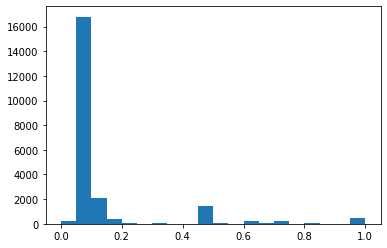

In [23]:
import matplotlib.pyplot as plt

train_proba = label_model.predict_proba(train_L)
plt.hist(train_proba[:, 1], bins=20, range=(0.0, 1.0))
plt.show()

## Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use our noisy training labels alongside the development set labels to train our end machine learning model. We start by filtering out training examples which did not recieve a label from any LF, as these examples contain no signal. Then we concatenate them with dev set examples.


In [24]:
import pandas as pd
from snorkel.analysis.utils import preds_to_probs

# Change dev labels 1D array to 2D probabilities array as required for training end model.
dev_label_probs = preds_to_probs(dev_labels, 2)
mask = train_L.max(1) != -1
combined_df = pd.concat([dev_df, train_df.iloc[mask]])
combined_proba = np.concatenate([dev_label_probs, train_proba[mask, :]], 0)

## II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaluation.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!

In [25]:
from tf_model import get_features_and_labels, get_model

model = get_model()
tokens, idx1, idx2, label_probs = get_features_and_labels(
    combined_df, combined_proba, tf.float32
)
batch_size = 64
num_epochs = 2  # TODO: Change this to ~10. Warning: Training takes tens of minutes!
model.fit(
    (tokens, idx1, idx2),
    label_probs,
    batch_size=batch_size,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=num_epochs,
)

W0726 20:08:31.354085 139759547201344 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0726 20:08:31.440810 139759547201344 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0726 20:08:31.689959 139759547201344 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0726 20:08:31.725985 139759547201344 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:46: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0726 20:08:31.780707 139759547201344 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0726 20:08:32.519088 139759547201344 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/2


  1/347 [..............................] - ETA: 4:07 - loss: 0.6879 - acc: 0.9062

  2/347 [..............................] - ETA: 2:28 - loss: 0.6372 - acc: 0.9219

  3/347 [..............................] - ETA: 1:54 - loss: 0.5867 - acc: 0.9323

  4/347 [..............................] - ETA: 2:05 - loss: 0.5485 - acc: 0.9297

  5/347 [..............................] - ETA: 2:07 - loss: 0.5067 - acc: 0.9375

  6/347 [..............................] - ETA: 2:01 - loss: 0.4862 - acc: 0.9297

  7/347 [..............................] - ETA: 1:49 - loss: 0.4529 - acc: 0.9353

  8/347 [..............................] - ETA: 1:47 - loss: 0.4332 - acc: 0.9336

  9/347 [..............................] - ETA: 1:50 - loss: 0.4166 - acc: 0.9323

 10/347 [..............................] - ETA: 1:42 - loss: 0.4028 - acc: 0.9312

 11/347 [..............................] - ETA: 1:36 - loss: 0.3947 - acc: 0.9290

 12/347 [>.............................] - ETA: 1:31 - loss: 0.3848 - acc: 0.9284

 13/347 [>.............................] - ETA: 1:27 - loss: 0.3707 - acc: 0.9303

 14/347 [>.............................] - ETA: 1:23 - loss: 0.3580 - acc: 0.9319

 15/347 [>.............................] - ETA: 1:20 - loss: 0.3469 - acc: 0.9333

 16/347 [>.............................] - ETA: 1:17 - loss: 0.3428 - acc: 0.9326

 17/347 [>.............................] - ETA: 1:15 - loss: 0.3342 - acc: 0.9338

 18/347 [>.............................] - ETA: 1:13 - loss: 0.3433 - acc: 0.9288

 19/347 [>.............................] - ETA: 1:11 - loss: 0.3419 - acc: 0.9276

 20/347 [>.............................] - ETA: 1:09 - loss: 0.3341 - acc: 0.9297

 21/347 [>.............................] - ETA: 1:07 - loss: 0.3314 - acc: 0.9293

 22/347 [>.............................] - ETA: 1:05 - loss: 0.3220 - acc: 0.9318

 23/347 [>.............................] - ETA: 1:04 - loss: 0.3183 - acc: 0.9321

 24/347 [=>............................] - ETA: 1:02 - loss: 0.3130 - acc: 0.9329

 25/347 [=>............................] - ETA: 1:01 - loss: 0.3080 - acc: 0.9337

 26/347 [=>............................] - ETA: 1:00 - loss: 0.3034 - acc: 0.9345

 27/347 [=>............................] - ETA: 59s - loss: 0.3131 - acc: 0.9306 

 28/347 [=>............................] - ETA: 1:00 - loss: 0.3109 - acc: 0.9308

 29/347 [=>............................] - ETA: 59s - loss: 0.3098 - acc: 0.9305 

 30/347 [=>............................] - ETA: 59s - loss: 0.3075 - acc: 0.9307

 31/347 [=>............................] - ETA: 59s - loss: 0.3065 - acc: 0.9304

 32/347 [=>............................] - ETA: 58s - loss: 0.3008 - acc: 0.9321

 33/347 [=>............................] - ETA: 58s - loss: 0.2987 - acc: 0.9323

 34/347 [=>............................] - ETA: 57s - loss: 0.2981 - acc: 0.9320

 35/347 [==>...........................] - ETA: 57s - loss: 0.2998 - acc: 0.9308

 36/347 [==>...........................] - ETA: 56s - loss: 0.2981 - acc: 0.9310

 37/347 [==>...........................] - ETA: 56s - loss: 0.2932 - acc: 0.9324

 38/347 [==>...........................] - ETA: 55s - loss: 0.2903 - acc: 0.9330

 39/347 [==>...........................] - ETA: 54s - loss: 0.2925 - acc: 0.9319

 40/347 [==>...........................] - ETA: 53s - loss: 0.2900 - acc: 0.9324

 41/347 [==>...........................] - ETA: 53s - loss: 0.2897 - acc: 0.9322

 42/347 [==>...........................] - ETA: 52s - loss: 0.2866 - acc: 0.9330

 43/347 [==>...........................] - ETA: 51s - loss: 0.2893 - acc: 0.9324

 44/347 [==>...........................] - ETA: 51s - loss: 0.2988 - acc: 0.9297

 45/347 [==>...........................] - ETA: 51s - loss: 0.3083 - acc: 0.9267

 46/347 [==>...........................] - ETA: 51s - loss: 0.3163 - acc: 0.9239

 47/347 [===>..........................] - ETA: 51s - loss: 0.3246 - acc: 0.9202

 48/347 [===>..........................] - ETA: 51s - loss: 0.3316 - acc: 0.9180

 49/347 [===>..........................] - ETA: 51s - loss: 0.3393 - acc: 0.9142

 50/347 [===>..........................] - ETA: 51s - loss: 0.3463 - acc: 0.9112

 51/347 [===>..........................] - ETA: 51s - loss: 0.3523 - acc: 0.9087

 52/347 [===>..........................] - ETA: 51s - loss: 0.3588 - acc: 0.9062

 53/347 [===>..........................] - ETA: 51s - loss: 0.3647 - acc: 0.9030

 54/347 [===>..........................] - ETA: 51s - loss: 0.3704 - acc: 0.8987

 55/347 [===>..........................] - ETA: 50s - loss: 0.3758 - acc: 0.8963

 56/347 [===>..........................] - ETA: 50s - loss: 0.3808 - acc: 0.8948

 57/347 [===>..........................] - ETA: 50s - loss: 0.3857 - acc: 0.8923

 58/347 [====>.........................] - ETA: 50s - loss: 0.3901 - acc: 0.8904

 59/347 [====>.........................] - ETA: 49s - loss: 0.3948 - acc: 0.8882

 60/347 [====>.........................] - ETA: 49s - loss: 0.3997 - acc: 0.8867

 61/347 [====>.........................] - ETA: 49s - loss: 0.4037 - acc: 0.8860

 62/347 [====>.........................] - ETA: 49s - loss: 0.4082 - acc: 0.8828

 63/347 [====>.........................] - ETA: 49s - loss: 0.4114 - acc: 0.8829

 64/347 [====>.........................] - ETA: 49s - loss: 0.4148 - acc: 0.8818

 65/347 [====>.........................] - ETA: 48s - loss: 0.4184 - acc: 0.8805

 66/347 [====>.........................] - ETA: 48s - loss: 0.4217 - acc: 0.8795

 67/347 [====>.........................] - ETA: 48s - loss: 0.4245 - acc: 0.8799

 68/347 [====>.........................] - ETA: 48s - loss: 0.4275 - acc: 0.8789

 69/347 [====>.........................] - ETA: 47s - loss: 0.4304 - acc: 0.8788

 70/347 [=====>........................] - ETA: 47s - loss: 0.4336 - acc: 0.8772

 71/347 [=====>........................] - ETA: 47s - loss: 0.4363 - acc: 0.8765

 72/347 [=====>........................] - ETA: 47s - loss: 0.4388 - acc: 0.8763

 73/347 [=====>........................] - ETA: 47s - loss: 0.4408 - acc: 0.8771

 74/347 [=====>........................] - ETA: 48s - loss: 0.4436 - acc: 0.8767

 75/347 [=====>........................] - ETA: 48s - loss: 0.4459 - acc: 0.8771

 76/347 [=====>........................] - ETA: 48s - loss: 0.4483 - acc: 0.8764

 77/347 [=====>........................] - ETA: 48s - loss: 0.4508 - acc: 0.8746

 78/347 [=====>........................] - ETA: 48s - loss: 0.4528 - acc: 0.8738

 79/347 [=====>........................] - ETA: 47s - loss: 0.4557 - acc: 0.8712

 80/347 [=====>........................] - ETA: 48s - loss: 0.4578 - acc: 0.8707

 81/347 [======>.......................] - ETA: 47s - loss: 0.4601 - acc: 0.8708

 82/347 [======>.......................] - ETA: 47s - loss: 0.4620 - acc: 0.8708

 83/347 [======>.......................] - ETA: 47s - loss: 0.4644 - acc: 0.8703

 84/347 [======>.......................] - ETA: 46s - loss: 0.4664 - acc: 0.8700

 85/347 [======>.......................] - ETA: 46s - loss: 0.4682 - acc: 0.8699

 86/347 [======>.......................] - ETA: 46s - loss: 0.4698 - acc: 0.8699

 87/347 [======>.......................] - ETA: 45s - loss: 0.4722 - acc: 0.8684

 88/347 [======>.......................] - ETA: 46s - loss: 0.4742 - acc: 0.8677

 89/347 [======>.......................] - ETA: 46s - loss: 0.4759 - acc: 0.8673

 90/347 [======>.......................] - ETA: 46s - loss: 0.4775 - acc: 0.8668

 91/347 [======>.......................] - ETA: 46s - loss: 0.4790 - acc: 0.8668

 92/347 [======>.......................] - ETA: 45s - loss: 0.4807 - acc: 0.8663

 93/347 [=======>......................] - ETA: 45s - loss: 0.4821 - acc: 0.8661

 94/347 [=======>......................] - ETA: 45s - loss: 0.4840 - acc: 0.8652

 95/347 [=======>......................] - ETA: 45s - loss: 0.4853 - acc: 0.8648

 96/347 [=======>......................] - ETA: 45s - loss: 0.4870 - acc: 0.8638

 97/347 [=======>......................] - ETA: 45s - loss: 0.4886 - acc: 0.8639

 98/347 [=======>......................] - ETA: 45s - loss: 0.4904 - acc: 0.8630

 99/347 [=======>......................] - ETA: 44s - loss: 0.4922 - acc: 0.8617

100/347 [=======>......................] - ETA: 44s - loss: 0.4935 - acc: 0.8616

101/347 [=======>......................] - ETA: 44s - loss: 0.4950 - acc: 0.8608

102/347 [=======>......................] - ETA: 44s - loss: 0.4967 - acc: 0.8597

103/347 [=======>......................] - ETA: 44s - loss: 0.4986 - acc: 0.8583

104/347 [=======>......................] - ETA: 44s - loss: 0.4997 - acc: 0.8588

105/347 [========>.....................] - ETA: 44s - loss: 0.5008 - acc: 0.8588

106/347 [========>.....................] - ETA: 44s - loss: 0.5024 - acc: 0.8578

107/347 [========>.....................] - ETA: 44s - loss: 0.5039 - acc: 0.8567

108/347 [========>.....................] - ETA: 44s - loss: 0.5054 - acc: 0.8559

109/347 [========>.....................] - ETA: 44s - loss: 0.5069 - acc: 0.8556

110/347 [========>.....................] - ETA: 44s - loss: 0.5085 - acc: 0.8548

111/347 [========>.....................] - ETA: 44s - loss: 0.5099 - acc: 0.8542

112/347 [========>.....................] - ETA: 44s - loss: 0.5108 - acc: 0.8544

113/347 [========>.....................] - ETA: 44s - loss: 0.5116 - acc: 0.8544

114/347 [========>.....................] - ETA: 43s - loss: 0.5127 - acc: 0.8538

115/347 [========>.....................] - ETA: 43s - loss: 0.5141 - acc: 0.8535

116/347 [=========>....................] - ETA: 43s - loss: 0.5154 - acc: 0.8526

117/347 [=========>....................] - ETA: 43s - loss: 0.5163 - acc: 0.8523

118/347 [=========>....................] - ETA: 42s - loss: 0.5174 - acc: 0.8518

119/347 [=========>....................] - ETA: 42s - loss: 0.5184 - acc: 0.8515

120/347 [=========>....................] - ETA: 42s - loss: 0.5193 - acc: 0.8517

121/347 [=========>....................] - ETA: 41s - loss: 0.5200 - acc: 0.8520

122/347 [=========>....................] - ETA: 41s - loss: 0.5214 - acc: 0.8513

123/347 [=========>....................] - ETA: 41s - loss: 0.5221 - acc: 0.8515

124/347 [=========>....................] - ETA: 41s - loss: 0.5230 - acc: 0.8508

125/347 [=========>....................] - ETA: 40s - loss: 0.5241 - acc: 0.8503

126/347 [=========>....................] - ETA: 40s - loss: 0.5252 - acc: 0.8493

127/347 [=========>....................] - ETA: 40s - loss: 0.5264 - acc: 0.8488

128/347 [==========>...................] - ETA: 40s - loss: 0.5274 - acc: 0.8481

129/347 [==========>...................] - ETA: 39s - loss: 0.5282 - acc: 0.8471

130/347 [==========>...................] - ETA: 39s - loss: 0.5289 - acc: 0.8466

131/347 [==========>...................] - ETA: 39s - loss: 0.5300 - acc: 0.8463

132/347 [==========>...................] - ETA: 39s - loss: 0.5308 - acc: 0.8456

133/347 [==========>...................] - ETA: 39s - loss: 0.5320 - acc: 0.8448

134/347 [==========>...................] - ETA: 38s - loss: 0.5321 - acc: 0.8450

135/347 [==========>...................] - ETA: 38s - loss: 0.5315 - acc: 0.8457

136/347 [==========>...................] - ETA: 38s - loss: 0.5308 - acc: 0.8463

137/347 [==========>...................] - ETA: 38s - loss: 0.5293 - acc: 0.8473

138/347 [==========>...................] - ETA: 38s - loss: 0.5279 - acc: 0.8481

139/347 [===========>..................] - ETA: 38s - loss: 0.5266 - acc: 0.8486

140/347 [===========>..................] - ETA: 38s - loss: 0.5253 - acc: 0.8490

141/347 [===========>..................] - ETA: 38s - loss: 0.5240 - acc: 0.8494

142/347 [===========>..................] - ETA: 38s - loss: 0.5221 - acc: 0.8501

143/347 [===========>..................] - ETA: 38s - loss: 0.5201 - acc: 0.8509

144/347 [===========>..................] - ETA: 38s - loss: 0.5184 - acc: 0.8513

145/347 [===========>..................] - ETA: 37s - loss: 0.5175 - acc: 0.8515

146/347 [===========>..................] - ETA: 37s - loss: 0.5154 - acc: 0.8522

147/347 [===========>..................] - ETA: 37s - loss: 0.5140 - acc: 0.8526

148/347 [===========>..................] - ETA: 36s - loss: 0.5119 - acc: 0.8533

149/347 [===========>..................] - ETA: 36s - loss: 0.5103 - acc: 0.8537

150/347 [===========>..................] - ETA: 36s - loss: 0.5080 - acc: 0.8545

151/347 [============>.................] - ETA: 36s - loss: 0.5070 - acc: 0.8547

152/347 [============>.................] - ETA: 35s - loss: 0.5052 - acc: 0.8553

153/347 [============>.................] - ETA: 35s - loss: 0.5042 - acc: 0.8555

154/347 [============>.................] - ETA: 35s - loss: 0.5027 - acc: 0.8559

155/347 [============>.................] - ETA: 35s - loss: 0.5010 - acc: 0.8565

156/347 [============>.................] - ETA: 34s - loss: 0.4991 - acc: 0.8571

157/347 [============>.................] - ETA: 34s - loss: 0.4974 - acc: 0.8576

158/347 [============>.................] - ETA: 34s - loss: 0.4955 - acc: 0.8582

159/347 [============>.................] - ETA: 33s - loss: 0.4938 - acc: 0.8587

160/347 [============>.................] - ETA: 33s - loss: 0.4924 - acc: 0.8591

161/347 [============>.................] - ETA: 33s - loss: 0.4908 - acc: 0.8596

162/347 [=============>................] - ETA: 33s - loss: 0.4890 - acc: 0.8601

163/347 [=============>................] - ETA: 33s - loss: 0.4885 - acc: 0.8602

164/347 [=============>................] - ETA: 32s - loss: 0.4876 - acc: 0.8604

165/347 [=============>................] - ETA: 32s - loss: 0.4866 - acc: 0.8607

166/347 [=============>................] - ETA: 32s - loss: 0.4849 - acc: 0.8613

167/347 [=============>................] - ETA: 32s - loss: 0.4832 - acc: 0.8618

168/347 [=============>................] - ETA: 32s - loss: 0.4814 - acc: 0.8624

169/347 [=============>................] - ETA: 31s - loss: 0.4810 - acc: 0.8624

170/347 [=============>................] - ETA: 31s - loss: 0.4793 - acc: 0.8630

171/347 [=============>................] - ETA: 31s - loss: 0.4772 - acc: 0.8637

172/347 [=============>................] - ETA: 31s - loss: 0.4755 - acc: 0.8642

173/347 [=============>................] - ETA: 31s - loss: 0.4738 - acc: 0.8647

174/347 [==============>...............] - ETA: 30s - loss: 0.4725 - acc: 0.8651

175/347 [==============>...............] - ETA: 30s - loss: 0.4713 - acc: 0.8654

176/347 [==============>...............] - ETA: 30s - loss: 0.4702 - acc: 0.8658

177/347 [==============>...............] - ETA: 30s - loss: 0.4717 - acc: 0.8651

178/347 [==============>...............] - ETA: 29s - loss: 0.4729 - acc: 0.8649

179/347 [==============>...............] - ETA: 29s - loss: 0.4742 - acc: 0.8646

180/347 [==============>...............] - ETA: 29s - loss: 0.4751 - acc: 0.8644

181/347 [==============>...............] - ETA: 29s - loss: 0.4765 - acc: 0.8638

182/347 [==============>...............] - ETA: 29s - loss: 0.4775 - acc: 0.8638

183/347 [==============>...............] - ETA: 29s - loss: 0.4786 - acc: 0.8634

184/347 [==============>...............] - ETA: 29s - loss: 0.4800 - acc: 0.8626

185/347 [==============>...............] - ETA: 28s - loss: 0.4813 - acc: 0.8616

186/347 [===============>..............] - ETA: 28s - loss: 0.4822 - acc: 0.8611

187/347 [===============>..............] - ETA: 28s - loss: 0.4833 - acc: 0.8605

188/347 [===============>..............] - ETA: 28s - loss: 0.4842 - acc: 0.8601

189/347 [===============>..............] - ETA: 28s - loss: 0.4851 - acc: 0.8597

190/347 [===============>..............] - ETA: 27s - loss: 0.4860 - acc: 0.8596

191/347 [===============>..............] - ETA: 27s - loss: 0.4870 - acc: 0.8587

192/347 [===============>..............] - ETA: 27s - loss: 0.4880 - acc: 0.8581

193/347 [===============>..............] - ETA: 27s - loss: 0.4891 - acc: 0.8574

194/347 [===============>..............] - ETA: 27s - loss: 0.4900 - acc: 0.8570

195/347 [===============>..............] - ETA: 26s - loss: 0.4907 - acc: 0.8567

196/347 [===============>..............] - ETA: 26s - loss: 0.4915 - acc: 0.8566

197/347 [================>.............] - ETA: 26s - loss: 0.4922 - acc: 0.8565

198/347 [================>.............] - ETA: 26s - loss: 0.4927 - acc: 0.8568

199/347 [================>.............] - ETA: 26s - loss: 0.4936 - acc: 0.8565

200/347 [================>.............] - ETA: 26s - loss: 0.4944 - acc: 0.8563

201/347 [================>.............] - ETA: 25s - loss: 0.4951 - acc: 0.8563

202/347 [================>.............] - ETA: 25s - loss: 0.4957 - acc: 0.8562

203/347 [================>.............] - ETA: 25s - loss: 0.4962 - acc: 0.8563

204/347 [================>.............] - ETA: 25s - loss: 0.4967 - acc: 0.8564

205/347 [================>.............] - ETA: 25s - loss: 0.4973 - acc: 0.8562

206/347 [================>.............] - ETA: 24s - loss: 0.4981 - acc: 0.8559

207/347 [================>.............] - ETA: 24s - loss: 0.4987 - acc: 0.8559

208/347 [================>.............] - ETA: 24s - loss: 0.4992 - acc: 0.8561

209/347 [=================>............] - ETA: 24s - loss: 0.4998 - acc: 0.8559

210/347 [=================>............] - ETA: 24s - loss: 0.5005 - acc: 0.8557

211/347 [=================>............] - ETA: 24s - loss: 0.5014 - acc: 0.8549

212/347 [=================>............] - ETA: 24s - loss: 0.5018 - acc: 0.8549

213/347 [=================>............] - ETA: 24s - loss: 0.5025 - acc: 0.8545

214/347 [=================>............] - ETA: 23s - loss: 0.5031 - acc: 0.8546

215/347 [=================>............] - ETA: 23s - loss: 0.5037 - acc: 0.8547

216/347 [=================>............] - ETA: 23s - loss: 0.5044 - acc: 0.8545

217/347 [=================>............] - ETA: 23s - loss: 0.5049 - acc: 0.8547

218/347 [=================>............] - ETA: 23s - loss: 0.5056 - acc: 0.8545

219/347 [=================>............] - ETA: 22s - loss: 0.5063 - acc: 0.8541

220/347 [==================>...........] - ETA: 22s - loss: 0.5069 - acc: 0.8539

221/347 [==================>...........] - ETA: 22s - loss: 0.5074 - acc: 0.8539

222/347 [==================>...........] - ETA: 22s - loss: 0.5080 - acc: 0.8537

223/347 [==================>...........] - ETA: 22s - loss: 0.5085 - acc: 0.8536

224/347 [==================>...........] - ETA: 21s - loss: 0.5091 - acc: 0.8532

225/347 [==================>...........] - ETA: 21s - loss: 0.5094 - acc: 0.8534

226/347 [==================>...........] - ETA: 21s - loss: 0.5098 - acc: 0.8536

227/347 [==================>...........] - ETA: 21s - loss: 0.5103 - acc: 0.8535

228/347 [==================>...........] - ETA: 21s - loss: 0.5108 - acc: 0.8531

229/347 [==================>...........] - ETA: 21s - loss: 0.5115 - acc: 0.8528

230/347 [==================>...........] - ETA: 20s - loss: 0.5122 - acc: 0.8526

231/347 [==================>...........] - ETA: 20s - loss: 0.5129 - acc: 0.8522

232/347 [===================>..........] - ETA: 20s - loss: 0.5133 - acc: 0.8522

233/347 [===================>..........] - ETA: 20s - loss: 0.5140 - acc: 0.8519

234/347 [===================>..........] - ETA: 20s - loss: 0.5148 - acc: 0.8514

235/347 [===================>..........] - ETA: 20s - loss: 0.5152 - acc: 0.8513

236/347 [===================>..........] - ETA: 20s - loss: 0.5158 - acc: 0.8511

237/347 [===================>..........] - ETA: 19s - loss: 0.5164 - acc: 0.8506

238/347 [===================>..........] - ETA: 19s - loss: 0.5168 - acc: 0.8508

239/347 [===================>..........] - ETA: 19s - loss: 0.5173 - acc: 0.8507

240/347 [===================>..........] - ETA: 19s - loss: 0.5179 - acc: 0.8504

241/347 [===================>..........] - ETA: 19s - loss: 0.5185 - acc: 0.8502

242/347 [===================>..........] - ETA: 19s - loss: 0.5192 - acc: 0.8496

243/347 [====================>.........] - ETA: 18s - loss: 0.5198 - acc: 0.8494

244/347 [====================>.........] - ETA: 18s - loss: 0.5203 - acc: 0.8495

245/347 [====================>.........] - ETA: 18s - loss: 0.5208 - acc: 0.8492

246/347 [====================>.........] - ETA: 18s - loss: 0.5212 - acc: 0.8493

247/347 [====================>.........] - ETA: 18s - loss: 0.5217 - acc: 0.8491

248/347 [====================>.........] - ETA: 17s - loss: 0.5223 - acc: 0.8488

249/347 [====================>.........] - ETA: 17s - loss: 0.5228 - acc: 0.8486

250/347 [====================>.........] - ETA: 17s - loss: 0.5231 - acc: 0.8486

251/347 [====================>.........] - ETA: 17s - loss: 0.5236 - acc: 0.8483

252/347 [====================>.........] - ETA: 17s - loss: 0.5240 - acc: 0.8483

253/347 [====================>.........] - ETA: 17s - loss: 0.5244 - acc: 0.8481

254/347 [====================>.........] - ETA: 16s - loss: 0.5249 - acc: 0.8477

255/347 [=====================>........] - ETA: 16s - loss: 0.5255 - acc: 0.8472

256/347 [=====================>........] - ETA: 16s - loss: 0.5259 - acc: 0.8475

257/347 [=====================>........] - ETA: 16s - loss: 0.5264 - acc: 0.8473

258/347 [=====================>........] - ETA: 15s - loss: 0.5268 - acc: 0.8472

259/347 [=====================>........] - ETA: 15s - loss: 0.5273 - acc: 0.8471

260/347 [=====================>........] - ETA: 15s - loss: 0.5278 - acc: 0.8468

261/347 [=====================>........] - ETA: 15s - loss: 0.5282 - acc: 0.8466

262/347 [=====================>........] - ETA: 15s - loss: 0.5287 - acc: 0.8460

263/347 [=====================>........] - ETA: 15s - loss: 0.5292 - acc: 0.8456

264/347 [=====================>........] - ETA: 14s - loss: 0.5296 - acc: 0.8455

265/347 [=====================>........] - ETA: 14s - loss: 0.5301 - acc: 0.8451

266/347 [=====================>........] - ETA: 14s - loss: 0.5306 - acc: 0.8448

267/347 [======================>.......] - ETA: 14s - loss: 0.5310 - acc: 0.8447

268/347 [======================>.......] - ETA: 14s - loss: 0.5308 - acc: 0.8449

269/347 [======================>.......] - ETA: 13s - loss: 0.5304 - acc: 0.8453

270/347 [======================>.......] - ETA: 13s - loss: 0.5299 - acc: 0.8457

271/347 [======================>.......] - ETA: 13s - loss: 0.5293 - acc: 0.8462

272/347 [======================>.......] - ETA: 13s - loss: 0.5288 - acc: 0.8463

273/347 [======================>.......] - ETA: 13s - loss: 0.5280 - acc: 0.8468

274/347 [======================>.......] - ETA: 13s - loss: 0.5273 - acc: 0.8471

275/347 [======================>.......] - ETA: 13s - loss: 0.5267 - acc: 0.8473

276/347 [======================>.......] - ETA: 12s - loss: 0.5259 - acc: 0.8475

277/347 [======================>.......] - ETA: 12s - loss: 0.5251 - acc: 0.8478

278/347 [=======================>......] - ETA: 12s - loss: 0.5242 - acc: 0.8481

279/347 [=======================>......] - ETA: 12s - loss: 0.5232 - acc: 0.8485

280/347 [=======================>......] - ETA: 12s - loss: 0.5224 - acc: 0.8487

281/347 [=======================>......] - ETA: 11s - loss: 0.5218 - acc: 0.8489

282/347 [=======================>......] - ETA: 11s - loss: 0.5207 - acc: 0.8492

283/347 [=======================>......] - ETA: 11s - loss: 0.5197 - acc: 0.8495

284/347 [=======================>......] - ETA: 11s - loss: 0.5184 - acc: 0.8500

285/347 [=======================>......] - ETA: 11s - loss: 0.5181 - acc: 0.8501

286/347 [=======================>......] - ETA: 11s - loss: 0.5174 - acc: 0.8502

287/347 [=======================>......] - ETA: 10s - loss: 0.5166 - acc: 0.8504

288/347 [=======================>......] - ETA: 10s - loss: 0.5153 - acc: 0.8509

289/347 [=======================>......] - ETA: 10s - loss: 0.5142 - acc: 0.8513

290/347 [========================>.....] - ETA: 10s - loss: 0.5128 - acc: 0.8517

291/347 [========================>.....] - ETA: 10s - loss: 0.5115 - acc: 0.8521

292/347 [========================>.....] - ETA: 9s - loss: 0.5110 - acc: 0.8523 

293/347 [========================>.....] - ETA: 9s - loss: 0.5104 - acc: 0.8524

294/347 [========================>.....] - ETA: 9s - loss: 0.5093 - acc: 0.8528

295/347 [========================>.....] - ETA: 9s - loss: 0.5089 - acc: 0.8529

296/347 [========================>.....] - ETA: 9s - loss: 0.5085 - acc: 0.8529

297/347 [========================>.....] - ETA: 8s - loss: 0.5075 - acc: 0.8533

298/347 [========================>.....] - ETA: 8s - loss: 0.5067 - acc: 0.8535

299/347 [========================>.....] - ETA: 8s - loss: 0.5062 - acc: 0.8536

300/347 [========================>.....] - ETA: 8s - loss: 0.5052 - acc: 0.8540

301/347 [=========================>....] - ETA: 8s - loss: 0.5043 - acc: 0.8542

302/347 [=========================>....] - ETA: 8s - loss: 0.5031 - acc: 0.8546

303/347 [=========================>....] - ETA: 7s - loss: 0.5019 - acc: 0.8550

304/347 [=========================>....] - ETA: 7s - loss: 0.5009 - acc: 0.8553

305/347 [=========================>....] - ETA: 7s - loss: 0.5003 - acc: 0.8555

306/347 [=========================>....] - ETA: 7s - loss: 0.4995 - acc: 0.8557

307/347 [=========================>....] - ETA: 7s - loss: 0.4985 - acc: 0.8561

308/347 [=========================>....] - ETA: 6s - loss: 0.4976 - acc: 0.8563

309/347 [=========================>....] - ETA: 6s - loss: 0.4966 - acc: 0.8566

310/347 [=========================>....] - ETA: 6s - loss: 0.4964 - acc: 0.8568

311/347 [=========================>....] - ETA: 6s - loss: 0.4976 - acc: 0.8563

312/347 [=========================>....] - ETA: 6s - loss: 0.4983 - acc: 0.8561

313/347 [==========================>...] - ETA: 6s - loss: 0.4989 - acc: 0.8559

314/347 [==========================>...] - ETA: 5s - loss: 0.4996 - acc: 0.8557

315/347 [==========================>...] - ETA: 5s - loss: 0.4998 - acc: 0.8558

316/347 [==========================>...] - ETA: 5s - loss: 0.5005 - acc: 0.8555

317/347 [==========================>...] - ETA: 5s - loss: 0.5013 - acc: 0.8551

318/347 [==========================>...] - ETA: 5s - loss: 0.5020 - acc: 0.8546

319/347 [==========================>...] - ETA: 4s - loss: 0.5027 - acc: 0.8542

320/347 [==========================>...] - ETA: 4s - loss: 0.5031 - acc: 0.8541

321/347 [==========================>...] - ETA: 4s - loss: 0.5037 - acc: 0.8537

322/347 [==========================>...] - ETA: 4s - loss: 0.5042 - acc: 0.8535

323/347 [==========================>...] - ETA: 4s - loss: 0.5046 - acc: 0.8535

324/347 [===========================>..] - ETA: 4s - loss: 0.5053 - acc: 0.8530

325/347 [===========================>..] - ETA: 3s - loss: 0.5058 - acc: 0.8529

326/347 [===========================>..] - ETA: 3s - loss: 0.5063 - acc: 0.8526

327/347 [===========================>..] - ETA: 3s - loss: 0.5069 - acc: 0.8522

328/347 [===========================>..] - ETA: 3s - loss: 0.5072 - acc: 0.8522

329/347 [===========================>..] - ETA: 3s - loss: 0.5077 - acc: 0.8520

330/347 [===========================>..] - ETA: 3s - loss: 0.5081 - acc: 0.8518

331/347 [===========================>..] - ETA: 2s - loss: 0.5084 - acc: 0.8517

332/347 [===========================>..] - ETA: 2s - loss: 0.5088 - acc: 0.8518

333/347 [===========================>..] - ETA: 2s - loss: 0.5093 - acc: 0.8515

334/347 [===========================>..] - ETA: 2s - loss: 0.5097 - acc: 0.8514

335/347 [===========================>..] - ETA: 2s - loss: 0.5100 - acc: 0.8514

336/347 [============================>.] - ETA: 1s - loss: 0.5102 - acc: 0.8516

337/347 [============================>.] - ETA: 1s - loss: 0.5107 - acc: 0.8514

338/347 [============================>.] - ETA: 1s - loss: 0.5109 - acc: 0.8516

339/347 [============================>.] - ETA: 1s - loss: 0.5114 - acc: 0.8515

340/347 [============================>.] - ETA: 1s - loss: 0.5116 - acc: 0.8517

341/347 [============================>.] - ETA: 1s - loss: 0.5119 - acc: 0.8517

342/347 [============================>.] - ETA: 0s - loss: 0.5122 - acc: 0.8517

343/347 [============================>.] - ETA: 0s - loss: 0.5125 - acc: 0.8519

344/347 [============================>.] - ETA: 0s - loss: 0.5129 - acc: 0.8516

345/347 [============================>.] - ETA: 0s - loss: 0.5132 - acc: 0.8514

346/347 [============================>.] - ETA: 0s - loss: 0.5135 - acc: 0.8512

347/347 [==============================] - 62s 179ms/step - loss: 0.5140 - acc: 0.8510


Epoch 2/2
  1/347 [..............................] - ETA: 49s - loss: 0.6424 - acc: 0.7969

  2/347 [..............................] - ETA: 50s - loss: 0.6451 - acc: 0.8359

  3/347 [..............................] - ETA: 46s - loss: 0.6509 - acc: 0.8281

  4/347 [..............................] - ETA: 44s - loss: 0.6502 - acc: 0.8203

  5/347 [..............................] - ETA: 43s - loss: 0.6397 - acc: 0.8313

  6/347 [..............................] - ETA: 43s - loss: 0.6302 - acc: 0.8438

  7/347 [..............................] - ETA: 43s - loss: 0.6377 - acc: 0.8237

  8/347 [..............................] - ETA: 48s - loss: 0.6335 - acc: 0.8262

  9/347 [..............................] - ETA: 47s - loss: 0.6327 - acc: 0.8264

 10/347 [..............................] - ETA: 51s - loss: 0.6312 - acc: 0.8328

 11/347 [..............................] - ETA: 50s - loss: 0.6331 - acc: 0.8324

 12/347 [>.............................] - ETA: 49s - loss: 0.6288 - acc: 0.8359

 13/347 [>.............................] - ETA: 51s - loss: 0.6327 - acc: 0.8281

 14/347 [>.............................] - ETA: 53s - loss: 0.6307 - acc: 0.8304

 15/347 [>.............................] - ETA: 53s - loss: 0.6306 - acc: 0.8281

 16/347 [>.............................] - ETA: 54s - loss: 0.6301 - acc: 0.8262

 17/347 [>.............................] - ETA: 54s - loss: 0.6324 - acc: 0.8244

 18/347 [>.............................] - ETA: 56s - loss: 0.6364 - acc: 0.8203

 19/347 [>.............................] - ETA: 57s - loss: 0.6366 - acc: 0.8183

 20/347 [>.............................] - ETA: 57s - loss: 0.6367 - acc: 0.8180

 21/347 [>.............................] - ETA: 1:00 - loss: 0.6377 - acc: 0.8162

 22/347 [>.............................] - ETA: 1:00 - loss: 0.6362 - acc: 0.8189

 23/347 [>.............................] - ETA: 1:02 - loss: 0.6374 - acc: 0.8166

 24/347 [=>............................] - ETA: 1:03 - loss: 0.6356 - acc: 0.8210

 25/347 [=>............................] - ETA: 1:03 - loss: 0.6352 - acc: 0.8213

 26/347 [=>............................] - ETA: 1:03 - loss: 0.6376 - acc: 0.8167

 27/347 [=>............................] - ETA: 1:02 - loss: 0.6409 - acc: 0.8137

 28/347 [=>............................] - ETA: 1:02 - loss: 0.6422 - acc: 0.8097

 29/347 [=>............................] - ETA: 1:02 - loss: 0.6421 - acc: 0.8103

 30/347 [=>............................] - ETA: 1:02 - loss: 0.6445 - acc: 0.8062

 31/347 [=>............................] - ETA: 1:02 - loss: 0.6450 - acc: 0.8054

 32/347 [=>............................] - ETA: 1:02 - loss: 0.6445 - acc: 0.8071

 33/347 [=>............................] - ETA: 1:02 - loss: 0.6434 - acc: 0.8097

 34/347 [=>............................] - ETA: 1:01 - loss: 0.6426 - acc: 0.8116

 35/347 [==>...........................] - ETA: 1:00 - loss: 0.6434 - acc: 0.8112

 36/347 [==>...........................] - ETA: 1:00 - loss: 0.6437 - acc: 0.8103

 37/347 [==>...........................] - ETA: 59s - loss: 0.6439 - acc: 0.8087 

 38/347 [==>...........................] - ETA: 59s - loss: 0.6426 - acc: 0.8104

 39/347 [==>...........................] - ETA: 58s - loss: 0.6421 - acc: 0.8113

 40/347 [==>...........................] - ETA: 57s - loss: 0.6422 - acc: 0.8105

 41/347 [==>...........................] - ETA: 57s - loss: 0.6419 - acc: 0.8110

 42/347 [==>...........................] - ETA: 56s - loss: 0.6421 - acc: 0.8103

 43/347 [==>...........................] - ETA: 56s - loss: 0.6415 - acc: 0.8125

 44/347 [==>...........................] - ETA: 55s - loss: 0.6420 - acc: 0.8114

 45/347 [==>...........................] - ETA: 55s - loss: 0.6422 - acc: 0.8111

 46/347 [==>...........................] - ETA: 54s - loss: 0.6420 - acc: 0.8115

 47/347 [===>..........................] - ETA: 54s - loss: 0.6431 - acc: 0.8088

 48/347 [===>..........................] - ETA: 54s - loss: 0.6433 - acc: 0.8076

 49/347 [===>..........................] - ETA: 53s - loss: 0.6438 - acc: 0.8058

 50/347 [===>..........................] - ETA: 53s - loss: 0.6438 - acc: 0.8037

 51/347 [===>..........................] - ETA: 53s - loss: 0.6437 - acc: 0.8045

 52/347 [===>..........................] - ETA: 52s - loss: 0.6440 - acc: 0.8038

 53/347 [===>..........................] - ETA: 53s - loss: 0.6435 - acc: 0.8048

 54/347 [===>..........................] - ETA: 52s - loss: 0.6420 - acc: 0.8050

 55/347 [===>..........................] - ETA: 52s - loss: 0.6384 - acc: 0.8077

 56/347 [===>..........................] - ETA: 51s - loss: 0.6342 - acc: 0.8105

 57/347 [===>..........................] - ETA: 51s - loss: 0.6313 - acc: 0.8114

 58/347 [====>.........................] - ETA: 52s - loss: 0.6279 - acc: 0.8128

 59/347 [====>.........................] - ETA: 53s - loss: 0.6233 - acc: 0.8151

 60/347 [====>.........................] - ETA: 54s - loss: 0.6188 - acc: 0.8172

 61/347 [====>.........................] - ETA: 53s - loss: 0.6151 - acc: 0.8184

 62/347 [====>.........................] - ETA: 54s - loss: 0.6095 - acc: 0.8211

 63/347 [====>.........................] - ETA: 53s - loss: 0.6046 - acc: 0.8229

 64/347 [====>.........................] - ETA: 54s - loss: 0.5994 - acc: 0.8250

 65/347 [====>.........................] - ETA: 54s - loss: 0.5953 - acc: 0.8262

 66/347 [====>.........................] - ETA: 53s - loss: 0.5912 - acc: 0.8274

 67/347 [====>.........................] - ETA: 53s - loss: 0.5856 - acc: 0.8295

 68/347 [====>.........................] - ETA: 52s - loss: 0.5808 - acc: 0.8311

 69/347 [====>.........................] - ETA: 52s - loss: 0.5764 - acc: 0.8324

 70/347 [=====>........................] - ETA: 51s - loss: 0.5713 - acc: 0.8342

 71/347 [=====>........................] - ETA: 51s - loss: 0.5667 - acc: 0.8356

 72/347 [=====>........................] - ETA: 51s - loss: 0.5645 - acc: 0.8359

 73/347 [=====>........................] - ETA: 50s - loss: 0.5620 - acc: 0.8365

 74/347 [=====>........................] - ETA: 50s - loss: 0.5568 - acc: 0.8383

 75/347 [=====>........................] - ETA: 49s - loss: 0.5507 - acc: 0.8404

 76/347 [=====>........................] - ETA: 49s - loss: 0.5460 - acc: 0.8419

 77/347 [=====>........................] - ETA: 48s - loss: 0.5425 - acc: 0.8429

 78/347 [=====>........................] - ETA: 48s - loss: 0.5386 - acc: 0.8442

 79/347 [=====>........................] - ETA: 47s - loss: 0.5337 - acc: 0.8457

 80/347 [=====>........................] - ETA: 47s - loss: 0.5299 - acc: 0.8469

 81/347 [======>.......................] - ETA: 47s - loss: 0.5273 - acc: 0.8476

 82/347 [======>.......................] - ETA: 47s - loss: 0.5256 - acc: 0.8479

 83/347 [======>.......................] - ETA: 46s - loss: 0.5244 - acc: 0.8481

 84/347 [======>.......................] - ETA: 46s - loss: 0.5214 - acc: 0.8490

 85/347 [======>.......................] - ETA: 46s - loss: 0.5190 - acc: 0.8496

 86/347 [======>.......................] - ETA: 46s - loss: 0.5145 - acc: 0.8512

 87/347 [======>.......................] - ETA: 46s - loss: 0.5104 - acc: 0.8526

 88/347 [======>.......................] - ETA: 45s - loss: 0.5077 - acc: 0.8533

 89/347 [======>.......................] - ETA: 45s - loss: 0.5042 - acc: 0.8545

 90/347 [======>.......................] - ETA: 45s - loss: 0.5030 - acc: 0.8547

 91/347 [======>.......................] - ETA: 44s - loss: 0.4996 - acc: 0.8558

 92/347 [======>.......................] - ETA: 44s - loss: 0.4968 - acc: 0.8567

 93/347 [=======>......................] - ETA: 44s - loss: 0.4931 - acc: 0.8579

 94/347 [=======>......................] - ETA: 43s - loss: 0.4903 - acc: 0.8587

 95/347 [=======>......................] - ETA: 43s - loss: 0.4885 - acc: 0.8592

 96/347 [=======>......................] - ETA: 43s - loss: 0.4871 - acc: 0.8595

 97/347 [=======>......................] - ETA: 43s - loss: 0.4867 - acc: 0.8599

 98/347 [=======>......................] - ETA: 43s - loss: 0.4895 - acc: 0.8591

 99/347 [=======>......................] - ETA: 43s - loss: 0.4920 - acc: 0.8583

100/347 [=======>......................] - ETA: 43s - loss: 0.4933 - acc: 0.8586

101/347 [=======>......................] - ETA: 42s - loss: 0.4952 - acc: 0.8581

102/347 [=======>......................] - ETA: 42s - loss: 0.4977 - acc: 0.8572

103/347 [=======>......................] - ETA: 42s - loss: 0.5001 - acc: 0.8560

104/347 [=======>......................] - ETA: 42s - loss: 0.5026 - acc: 0.8550

105/347 [========>.....................] - ETA: 42s - loss: 0.5044 - acc: 0.8540

106/347 [========>.....................] - ETA: 42s - loss: 0.5064 - acc: 0.8529

107/347 [========>.....................] - ETA: 42s - loss: 0.5086 - acc: 0.8513

108/347 [========>.....................] - ETA: 42s - loss: 0.5103 - acc: 0.8504

109/347 [========>.....................] - ETA: 42s - loss: 0.5110 - acc: 0.8506

110/347 [========>.....................] - ETA: 41s - loss: 0.5127 - acc: 0.8499

111/347 [========>.....................] - ETA: 41s - loss: 0.5138 - acc: 0.8491

112/347 [========>.....................] - ETA: 41s - loss: 0.5150 - acc: 0.8489

113/347 [========>.....................] - ETA: 40s - loss: 0.5172 - acc: 0.8467

114/347 [========>.....................] - ETA: 40s - loss: 0.5185 - acc: 0.8462

115/347 [========>.....................] - ETA: 40s - loss: 0.5195 - acc: 0.8462

116/347 [=========>....................] - ETA: 40s - loss: 0.5206 - acc: 0.8462

117/347 [=========>....................] - ETA: 40s - loss: 0.5216 - acc: 0.8458

118/347 [=========>....................] - ETA: 40s - loss: 0.5222 - acc: 0.8460

119/347 [=========>....................] - ETA: 39s - loss: 0.5237 - acc: 0.8451

120/347 [=========>....................] - ETA: 39s - loss: 0.5248 - acc: 0.8447

121/347 [=========>....................] - ETA: 39s - loss: 0.5255 - acc: 0.8452

122/347 [=========>....................] - ETA: 39s - loss: 0.5262 - acc: 0.8452

123/347 [=========>....................] - ETA: 39s - loss: 0.5269 - acc: 0.8455

124/347 [=========>....................] - ETA: 39s - loss: 0.5277 - acc: 0.8454

125/347 [=========>....................] - ETA: 38s - loss: 0.5282 - acc: 0.8456

126/347 [=========>....................] - ETA: 38s - loss: 0.5287 - acc: 0.8462

127/347 [=========>....................] - ETA: 38s - loss: 0.5300 - acc: 0.8455

128/347 [==========>...................] - ETA: 38s - loss: 0.5306 - acc: 0.8458

129/347 [==========>...................] - ETA: 39s - loss: 0.5314 - acc: 0.8456

130/347 [==========>...................] - ETA: 38s - loss: 0.5320 - acc: 0.8456

131/347 [==========>...................] - ETA: 38s - loss: 0.5328 - acc: 0.8452

132/347 [==========>...................] - ETA: 38s - loss: 0.5334 - acc: 0.8449

133/347 [==========>...................] - ETA: 38s - loss: 0.5342 - acc: 0.8448

134/347 [==========>...................] - ETA: 38s - loss: 0.5349 - acc: 0.8444

135/347 [==========>...................] - ETA: 38s - loss: 0.5356 - acc: 0.8442

136/347 [==========>...................] - ETA: 37s - loss: 0.5365 - acc: 0.8442

137/347 [==========>...................] - ETA: 37s - loss: 0.5376 - acc: 0.8438

138/347 [==========>...................] - ETA: 37s - loss: 0.5384 - acc: 0.8435

139/347 [===========>..................] - ETA: 37s - loss: 0.5390 - acc: 0.8434

140/347 [===========>..................] - ETA: 36s - loss: 0.5397 - acc: 0.8433

141/347 [===========>..................] - ETA: 36s - loss: 0.5405 - acc: 0.8429

142/347 [===========>..................] - ETA: 36s - loss: 0.5412 - acc: 0.8429

143/347 [===========>..................] - ETA: 36s - loss: 0.5418 - acc: 0.8428

144/347 [===========>..................] - ETA: 36s - loss: 0.5424 - acc: 0.8428

145/347 [===========>..................] - ETA: 36s - loss: 0.5427 - acc: 0.8429

146/347 [===========>..................] - ETA: 36s - loss: 0.5432 - acc: 0.8430

147/347 [===========>..................] - ETA: 36s - loss: 0.5435 - acc: 0.8431

148/347 [===========>..................] - ETA: 36s - loss: 0.5439 - acc: 0.8432

149/347 [===========>..................] - ETA: 35s - loss: 0.5445 - acc: 0.8431

150/347 [===========>..................] - ETA: 35s - loss: 0.5454 - acc: 0.8427

151/347 [============>.................] - ETA: 35s - loss: 0.5463 - acc: 0.8423

152/347 [============>.................] - ETA: 35s - loss: 0.5467 - acc: 0.8423

153/347 [============>.................] - ETA: 35s - loss: 0.5474 - acc: 0.8419

154/347 [============>.................] - ETA: 35s - loss: 0.5481 - acc: 0.8417

155/347 [============>.................] - ETA: 35s - loss: 0.5489 - acc: 0.8411

156/347 [============>.................] - ETA: 35s - loss: 0.5497 - acc: 0.8402

157/347 [============>.................] - ETA: 35s - loss: 0.5503 - acc: 0.8398

158/347 [============>.................] - ETA: 35s - loss: 0.5507 - acc: 0.8399

159/347 [============>.................] - ETA: 34s - loss: 0.5511 - acc: 0.8403

160/347 [============>.................] - ETA: 34s - loss: 0.5519 - acc: 0.8396

161/347 [============>.................] - ETA: 34s - loss: 0.5528 - acc: 0.8390

162/347 [=============>................] - ETA: 34s - loss: 0.5533 - acc: 0.8392

163/347 [=============>................] - ETA: 34s - loss: 0.5543 - acc: 0.8383

164/347 [=============>................] - ETA: 34s - loss: 0.5548 - acc: 0.8381

165/347 [=============>................] - ETA: 33s - loss: 0.5555 - acc: 0.8378

166/347 [=============>................] - ETA: 33s - loss: 0.5559 - acc: 0.8380

167/347 [=============>................] - ETA: 33s - loss: 0.5563 - acc: 0.8381

168/347 [=============>................] - ETA: 33s - loss: 0.5569 - acc: 0.8378

169/347 [=============>................] - ETA: 33s - loss: 0.5574 - acc: 0.8376

170/347 [=============>................] - ETA: 32s - loss: 0.5578 - acc: 0.8373

171/347 [=============>................] - ETA: 32s - loss: 0.5584 - acc: 0.8371

172/347 [=============>................] - ETA: 32s - loss: 0.5589 - acc: 0.8367

173/347 [=============>................] - ETA: 32s - loss: 0.5594 - acc: 0.8364

174/347 [==============>...............] - ETA: 31s - loss: 0.5597 - acc: 0.8367

175/347 [==============>...............] - ETA: 31s - loss: 0.5602 - acc: 0.8363

176/347 [==============>...............] - ETA: 31s - loss: 0.5606 - acc: 0.8364

177/347 [==============>...............] - ETA: 31s - loss: 0.5609 - acc: 0.8365

178/347 [==============>...............] - ETA: 30s - loss: 0.5615 - acc: 0.8365

179/347 [==============>...............] - ETA: 30s - loss: 0.5620 - acc: 0.8362

180/347 [==============>...............] - ETA: 30s - loss: 0.5626 - acc: 0.8356

181/347 [==============>...............] - ETA: 30s - loss: 0.5631 - acc: 0.8353

182/347 [==============>...............] - ETA: 30s - loss: 0.5637 - acc: 0.8346

183/347 [==============>...............] - ETA: 29s - loss: 0.5639 - acc: 0.8347

184/347 [==============>...............] - ETA: 29s - loss: 0.5646 - acc: 0.8336

185/347 [==============>...............] - ETA: 29s - loss: 0.5650 - acc: 0.8334

186/347 [===============>..............] - ETA: 29s - loss: 0.5655 - acc: 0.8330

187/347 [===============>..............] - ETA: 29s - loss: 0.5658 - acc: 0.8329

188/347 [===============>..............] - ETA: 28s - loss: 0.5654 - acc: 0.8334

189/347 [===============>..............] - ETA: 28s - loss: 0.5646 - acc: 0.8342

190/347 [===============>..............] - ETA: 28s - loss: 0.5638 - acc: 0.8348

191/347 [===============>..............] - ETA: 28s - loss: 0.5633 - acc: 0.8349

192/347 [===============>..............] - ETA: 28s - loss: 0.5623 - acc: 0.8355

193/347 [===============>..............] - ETA: 28s - loss: 0.5614 - acc: 0.8360

194/347 [===============>..............] - ETA: 28s - loss: 0.5605 - acc: 0.8363

195/347 [===============>..............] - ETA: 27s - loss: 0.5592 - acc: 0.8370

196/347 [===============>..............] - ETA: 27s - loss: 0.5580 - acc: 0.8375

197/347 [================>.............] - ETA: 27s - loss: 0.5570 - acc: 0.8379

198/347 [================>.............] - ETA: 27s - loss: 0.5557 - acc: 0.8384

199/347 [================>.............] - ETA: 27s - loss: 0.5545 - acc: 0.8388

200/347 [================>.............] - ETA: 26s - loss: 0.5533 - acc: 0.8392

201/347 [================>.............] - ETA: 26s - loss: 0.5519 - acc: 0.8397

202/347 [================>.............] - ETA: 26s - loss: 0.5505 - acc: 0.8402

203/347 [================>.............] - ETA: 26s - loss: 0.5491 - acc: 0.8407

204/347 [================>.............] - ETA: 26s - loss: 0.5476 - acc: 0.8411

205/347 [================>.............] - ETA: 25s - loss: 0.5465 - acc: 0.8415

206/347 [================>.............] - ETA: 25s - loss: 0.5450 - acc: 0.8419

207/347 [================>.............] - ETA: 25s - loss: 0.5436 - acc: 0.8424

208/347 [================>.............] - ETA: 25s - loss: 0.5423 - acc: 0.8428

209/347 [=================>............] - ETA: 24s - loss: 0.5415 - acc: 0.8429

210/347 [=================>............] - ETA: 24s - loss: 0.5395 - acc: 0.8437

211/347 [=================>............] - ETA: 24s - loss: 0.5380 - acc: 0.8441

212/347 [=================>............] - ETA: 24s - loss: 0.5366 - acc: 0.8446

213/347 [=================>............] - ETA: 23s - loss: 0.5352 - acc: 0.8450

214/347 [=================>............] - ETA: 23s - loss: 0.5343 - acc: 0.8452

215/347 [=================>............] - ETA: 23s - loss: 0.5334 - acc: 0.8454

216/347 [=================>............] - ETA: 23s - loss: 0.5320 - acc: 0.8458

217/347 [=================>............] - ETA: 23s - loss: 0.5312 - acc: 0.8461

218/347 [=================>............] - ETA: 23s - loss: 0.5302 - acc: 0.8463

219/347 [=================>............] - ETA: 22s - loss: 0.5290 - acc: 0.8467

220/347 [==================>...........] - ETA: 22s - loss: 0.5270 - acc: 0.8474

221/347 [==================>...........] - ETA: 22s - loss: 0.5257 - acc: 0.8478

222/347 [==================>...........] - ETA: 22s - loss: 0.5240 - acc: 0.8483

223/347 [==================>...........] - ETA: 22s - loss: 0.5225 - acc: 0.8488

224/347 [==================>...........] - ETA: 21s - loss: 0.5212 - acc: 0.8492

225/347 [==================>...........] - ETA: 21s - loss: 0.5198 - acc: 0.8497

226/347 [==================>...........] - ETA: 21s - loss: 0.5187 - acc: 0.8500

227/347 [==================>...........] - ETA: 21s - loss: 0.5172 - acc: 0.8504

228/347 [==================>...........] - ETA: 21s - loss: 0.5158 - acc: 0.8509

229/347 [==================>...........] - ETA: 20s - loss: 0.5149 - acc: 0.8511

230/347 [==================>...........] - ETA: 20s - loss: 0.5145 - acc: 0.8513

231/347 [==================>...........] - ETA: 20s - loss: 0.5156 - acc: 0.8509

232/347 [===================>..........] - ETA: 20s - loss: 0.5169 - acc: 0.8504

233/347 [===================>..........] - ETA: 20s - loss: 0.5175 - acc: 0.8504

234/347 [===================>..........] - ETA: 19s - loss: 0.5184 - acc: 0.8501

235/347 [===================>..........] - ETA: 19s - loss: 0.5193 - acc: 0.8499

236/347 [===================>..........] - ETA: 19s - loss: 0.5202 - acc: 0.8496

237/347 [===================>..........] - ETA: 19s - loss: 0.5210 - acc: 0.8492

238/347 [===================>..........] - ETA: 19s - loss: 0.5217 - acc: 0.8489

239/347 [===================>..........] - ETA: 19s - loss: 0.5223 - acc: 0.8485

240/347 [===================>..........] - ETA: 18s - loss: 0.5232 - acc: 0.8479

241/347 [===================>..........] - ETA: 18s - loss: 0.5236 - acc: 0.8480

242/347 [===================>..........] - ETA: 18s - loss: 0.5246 - acc: 0.8473

243/347 [====================>.........] - ETA: 18s - loss: 0.5251 - acc: 0.8472

244/347 [====================>.........] - ETA: 18s - loss: 0.5257 - acc: 0.8470

245/347 [====================>.........] - ETA: 18s - loss: 0.5262 - acc: 0.8467

246/347 [====================>.........] - ETA: 17s - loss: 0.5271 - acc: 0.8461

247/347 [====================>.........] - ETA: 17s - loss: 0.5277 - acc: 0.8460

248/347 [====================>.........] - ETA: 17s - loss: 0.5281 - acc: 0.8457

249/347 [====================>.........] - ETA: 17s - loss: 0.5286 - acc: 0.8456

250/347 [====================>.........] - ETA: 17s - loss: 0.5291 - acc: 0.8452

251/347 [====================>.........] - ETA: 16s - loss: 0.5293 - acc: 0.8453

252/347 [====================>.........] - ETA: 16s - loss: 0.5298 - acc: 0.8452

253/347 [====================>.........] - ETA: 16s - loss: 0.5303 - acc: 0.8450

254/347 [====================>.........] - ETA: 16s - loss: 0.5307 - acc: 0.8452

255/347 [=====================>........] - ETA: 16s - loss: 0.5313 - acc: 0.8448

256/347 [=====================>........] - ETA: 16s - loss: 0.5316 - acc: 0.8448

257/347 [=====================>........] - ETA: 15s - loss: 0.5319 - acc: 0.8449

258/347 [=====================>........] - ETA: 15s - loss: 0.5322 - acc: 0.8453

259/347 [=====================>........] - ETA: 15s - loss: 0.5327 - acc: 0.8451

260/347 [=====================>........] - ETA: 15s - loss: 0.5329 - acc: 0.8454

261/347 [=====================>........] - ETA: 15s - loss: 0.5332 - acc: 0.8454

262/347 [=====================>........] - ETA: 14s - loss: 0.5336 - acc: 0.8454

263/347 [=====================>........] - ETA: 14s - loss: 0.5340 - acc: 0.8452

264/347 [=====================>........] - ETA: 14s - loss: 0.5344 - acc: 0.8451

265/347 [=====================>........] - ETA: 14s - loss: 0.5346 - acc: 0.8451

266/347 [=====================>........] - ETA: 14s - loss: 0.5349 - acc: 0.8448

267/347 [======================>.......] - ETA: 14s - loss: 0.5354 - acc: 0.8445

268/347 [======================>.......] - ETA: 13s - loss: 0.5358 - acc: 0.8444

269/347 [======================>.......] - ETA: 13s - loss: 0.5362 - acc: 0.8444

270/347 [======================>.......] - ETA: 13s - loss: 0.5367 - acc: 0.8444

271/347 [======================>.......] - ETA: 13s - loss: 0.5372 - acc: 0.8441

272/347 [======================>.......] - ETA: 13s - loss: 0.5374 - acc: 0.8442

273/347 [======================>.......] - ETA: 12s - loss: 0.5377 - acc: 0.8443

274/347 [======================>.......] - ETA: 12s - loss: 0.5379 - acc: 0.8444

275/347 [======================>.......] - ETA: 12s - loss: 0.5382 - acc: 0.8445

276/347 [======================>.......] - ETA: 12s - loss: 0.5385 - acc: 0.8445

277/347 [======================>.......] - ETA: 12s - loss: 0.5389 - acc: 0.8442

278/347 [=======================>......] - ETA: 12s - loss: 0.5393 - acc: 0.8440

279/347 [=======================>......] - ETA: 12s - loss: 0.5395 - acc: 0.8441

280/347 [=======================>......] - ETA: 11s - loss: 0.5398 - acc: 0.8439

281/347 [=======================>......] - ETA: 11s - loss: 0.5402 - acc: 0.8438

282/347 [=======================>......] - ETA: 11s - loss: 0.5405 - acc: 0.8439

283/347 [=======================>......] - ETA: 11s - loss: 0.5409 - acc: 0.8436

284/347 [=======================>......] - ETA: 11s - loss: 0.5413 - acc: 0.8435

285/347 [=======================>......] - ETA: 11s - loss: 0.5417 - acc: 0.8435

286/347 [=======================>......] - ETA: 10s - loss: 0.5421 - acc: 0.8431

287/347 [=======================>......] - ETA: 10s - loss: 0.5424 - acc: 0.8431

288/347 [=======================>......] - ETA: 10s - loss: 0.5428 - acc: 0.8429

289/347 [=======================>......] - ETA: 10s - loss: 0.5432 - acc: 0.8426

290/347 [========================>.....] - ETA: 10s - loss: 0.5437 - acc: 0.8422

291/347 [========================>.....] - ETA: 10s - loss: 0.5439 - acc: 0.8422

292/347 [========================>.....] - ETA: 9s - loss: 0.5441 - acc: 0.8423 

293/347 [========================>.....] - ETA: 9s - loss: 0.5445 - acc: 0.8422

294/347 [========================>.....] - ETA: 9s - loss: 0.5451 - acc: 0.8415

295/347 [========================>.....] - ETA: 9s - loss: 0.5455 - acc: 0.8413

296/347 [========================>.....] - ETA: 9s - loss: 0.5459 - acc: 0.8412

297/347 [========================>.....] - ETA: 8s - loss: 0.5463 - acc: 0.8411

298/347 [========================>.....] - ETA: 8s - loss: 0.5466 - acc: 0.8410

299/347 [========================>.....] - ETA: 8s - loss: 0.5469 - acc: 0.8409

300/347 [========================>.....] - ETA: 8s - loss: 0.5471 - acc: 0.8410

301/347 [=========================>....] - ETA: 8s - loss: 0.5474 - acc: 0.8409

302/347 [=========================>....] - ETA: 8s - loss: 0.5479 - acc: 0.8408

303/347 [=========================>....] - ETA: 7s - loss: 0.5482 - acc: 0.8407

304/347 [=========================>....] - ETA: 7s - loss: 0.5485 - acc: 0.8405

305/347 [=========================>....] - ETA: 7s - loss: 0.5488 - acc: 0.8401

306/347 [=========================>....] - ETA: 7s - loss: 0.5491 - acc: 0.8400

307/347 [=========================>....] - ETA: 7s - loss: 0.5494 - acc: 0.8400

308/347 [=========================>....] - ETA: 6s - loss: 0.5497 - acc: 0.8399

309/347 [=========================>....] - ETA: 6s - loss: 0.5499 - acc: 0.8399

310/347 [=========================>....] - ETA: 6s - loss: 0.5501 - acc: 0.8400

311/347 [=========================>....] - ETA: 6s - loss: 0.5504 - acc: 0.8399

312/347 [=========================>....] - ETA: 6s - loss: 0.5508 - acc: 0.8396

313/347 [==========================>...] - ETA: 6s - loss: 0.5511 - acc: 0.8396

314/347 [==========================>...] - ETA: 5s - loss: 0.5515 - acc: 0.8394

315/347 [==========================>...] - ETA: 5s - loss: 0.5518 - acc: 0.8390

316/347 [==========================>...] - ETA: 5s - loss: 0.5521 - acc: 0.8388

317/347 [==========================>...] - ETA: 5s - loss: 0.5524 - acc: 0.8384

318/347 [==========================>...] - ETA: 5s - loss: 0.5527 - acc: 0.8383

319/347 [==========================>...] - ETA: 4s - loss: 0.5529 - acc: 0.8383

320/347 [==========================>...] - ETA: 4s - loss: 0.5532 - acc: 0.8380

321/347 [==========================>...] - ETA: 4s - loss: 0.5534 - acc: 0.8379

322/347 [==========================>...] - ETA: 4s - loss: 0.5531 - acc: 0.8382

323/347 [==========================>...] - ETA: 4s - loss: 0.5527 - acc: 0.8385

324/347 [===========================>..] - ETA: 4s - loss: 0.5522 - acc: 0.8389

325/347 [===========================>..] - ETA: 3s - loss: 0.5518 - acc: 0.8391

326/347 [===========================>..] - ETA: 3s - loss: 0.5512 - acc: 0.8395

327/347 [===========================>..] - ETA: 3s - loss: 0.5508 - acc: 0.8397

328/347 [===========================>..] - ETA: 3s - loss: 0.5500 - acc: 0.8401

329/347 [===========================>..] - ETA: 3s - loss: 0.5495 - acc: 0.8403

330/347 [===========================>..] - ETA: 3s - loss: 0.5487 - acc: 0.8407

331/347 [===========================>..] - ETA: 2s - loss: 0.5481 - acc: 0.8409

332/347 [===========================>..] - ETA: 2s - loss: 0.5475 - acc: 0.8411

333/347 [===========================>..] - ETA: 2s - loss: 0.5466 - acc: 0.8415

334/347 [===========================>..] - ETA: 2s - loss: 0.5460 - acc: 0.8416

335/347 [===========================>..] - ETA: 2s - loss: 0.5451 - acc: 0.8420

336/347 [============================>.] - ETA: 1s - loss: 0.5443 - acc: 0.8423

337/347 [============================>.] - ETA: 1s - loss: 0.5436 - acc: 0.8425

338/347 [============================>.] - ETA: 1s - loss: 0.5425 - acc: 0.8429

339/347 [============================>.] - ETA: 1s - loss: 0.5420 - acc: 0.8430

340/347 [============================>.] - ETA: 1s - loss: 0.5415 - acc: 0.8431

341/347 [============================>.] - ETA: 1s - loss: 0.5410 - acc: 0.8432

342/347 [============================>.] - ETA: 0s - loss: 0.5399 - acc: 0.8436

343/347 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.8439

344/347 [============================>.] - ETA: 0s - loss: 0.5379 - acc: 0.8442

345/347 [============================>.] - ETA: 0s - loss: 0.5371 - acc: 0.8445

346/347 [============================>.] - ETA: 0s - loss: 0.5361 - acc: 0.8448

347/347 [==============================] - 61s 177ms/step - loss: 0.5359 - acc: 0.8448


Measure the trained model's prediction accuracy.

In [26]:
# Truncate sentences to limit memory usage when padding.
def get_feature_arrays(df):
    def pad_or_truncate(l, max_length=60):
        return l[:max_length] + [""] * (max_length - len(l))

    tokens = np.array(list(map(pad_or_truncate, df.tokens)))
    idx1 = np.array(list(map(list, df.person1_word_idx)))
    idx2 = np.array(list(map(list, df.person2_word_idx)))
    return tokens, idx1, idx2


test_tokens, test_idx1, test_idx2 = get_feature_arrays(test_df)
probs = model.predict((test_tokens, test_idx1, test_idx2))
preds = probs_to_preds(probs)
print(
    f"Test Accuracy when trained with soft labels: {metric_score(test_labels, preds=preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(test_labels, probs=probs, metric='roc_auc')}"
)

Test Accuracy when trained with soft labels: 0.9192891521658645
Test ROC-AUC when trained with soft labels: 0.5440204399088111


We compare this to an equivalent model that is only trained using the dev set labels. The accuracy is similar in other cases, because the dataset is very unbalanced. However, the ROC-AUC is lower when just training on the dev set, due to the much smaller number of examples.

In [27]:
dev_model = get_model()
dev_tokens, dev_idx1, dev_idx2 = get_feature_arrays(dev_df)
num_epochs = 10  # TODO: Change this to 100.
dev_model.fit(
    (dev_tokens, dev_idx1, dev_idx2),
    dev_label_probs,
    batch_size=batch_size,
    epochs=num_epochs,
)

dev_probs = dev_model.predict((test_tokens, test_idx1, test_idx2))
dev_preds = probs_to_preds(dev_probs)
print(
    f"Test Accuracy when trained with dev labels: {metric_score(test_labels, preds=dev_preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with dev labels: {metric_score(test_labels, probs=dev_probs, metric='roc_auc')}"
)

Epoch 1/10


  64/2811 [..............................] - ETA: 22s - loss: 0.6963 - acc: 0.1562

 128/2811 [>.............................] - ETA: 11s - loss: 0.6421 - acc: 0.5312

 192/2811 [=>............................] - ETA: 8s - loss: 0.5942 - acc: 0.6667 

 320/2811 [==>...........................] - ETA: 5s - loss: 0.5166 - acc: 0.7750

 384/2811 [===>..........................] - ETA: 4s - loss: 0.4882 - acc: 0.7995

 448/2811 [===>..........................] - ETA: 4s - loss: 0.4673 - acc: 0.8147

 512/2811 [====>.........................] - ETA: 3s - loss: 0.4499 - acc: 0.8262

 640/2811 [=====>........................] - ETA: 3s - loss: 0.4145 - acc: 0.8469

 704/2811 [======>.......................] - ETA: 3s - loss: 0.4052 - acc: 0.8523

 768/2811 [=======>......................] - ETA: 2s - loss: 0.3944 - acc: 0.8581

 832/2811 [=======>......................] - ETA: 2s - loss: 0.3879 - acc: 0.8618

 896/2811 [========>.....................] - ETA: 2s - loss: 0.3824 - acc: 0.8650

 960/2811 [=========>....................] - ETA: 2s - loss: 0.3658 - acc: 0.8729

1024/2811 [=========>....................] - ETA: 2s - loss: 0.3522 - acc: 0.8789

1088/2811 [==========>...................] - ETA: 2s - loss: 0.3541 - acc: 0.8796

1152/2811 [===========>..................] - ETA: 1s - loss: 0.3438 - acc: 0.8845

1216/2811 [===========>..................] - ETA: 1s - loss: 0.3402 - acc: 0.8865

1280/2811 [============>.................] - ETA: 1s - loss: 0.3387 - acc: 0.8875

1344/2811 [=============>................] - ETA: 1s - loss: 0.3303 - acc: 0.8914

1408/2811 [==============>...............] - ETA: 1s - loss: 0.3260 - acc: 0.8935

1472/2811 [==============>...............] - ETA: 1s - loss: 0.3221 - acc: 0.8954

1600/2811 [================>.............] - ETA: 1s - loss: 0.3134 - acc: 0.8994

1664/2811 [================>.............] - ETA: 1s - loss: 0.3088 - acc: 0.9014

1728/2811 [=================>............] - ETA: 1s - loss: 0.3093 - acc: 0.9016

1792/2811 [==================>...........] - ETA: 1s - loss: 0.3108 - acc: 0.9012

1856/2811 [==================>...........] - ETA: 0s - loss: 0.3071 - acc: 0.9030

1920/2811 [===================>..........] - ETA: 0s - loss: 0.3073 - acc: 0.9031

1984/2811 [====================>.........] - ETA: 0s - loss: 0.3039 - acc: 0.9047

2048/2811 [====================>.........] - ETA: 0s - loss: 0.3004 - acc: 0.9062

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2998 - acc: 0.9067

2176/2811 [======================>.......] - ETA: 0s - loss: 0.3002 - acc: 0.9067

2240/2811 [======================>.......] - ETA: 0s - loss: 0.3016 - acc: 0.9062

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2999 - acc: 0.9071

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2952 - acc: 0.9092

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2900 - acc: 0.9112

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2875 - acc: 0.9125

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2882 - acc: 0.9123

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2851 - acc: 0.9137

2752/2811 [============================>.] - ETA: 0s - loss: 0.2869 - acc: 0.9132

2811/2811 [==============================] - 3s 960us/sample - loss: 0.2853 - acc: 0.9139


Epoch 2/10


  64/2811 [..............................] - ETA: 2s - loss: 0.1129 - acc: 0.9844

 128/2811 [>.............................] - ETA: 2s - loss: 0.1271 - acc: 0.9766

 192/2811 [=>............................] - ETA: 2s - loss: 0.1460 - acc: 0.9688

 256/2811 [=>............................] - ETA: 2s - loss: 0.1941 - acc: 0.9531

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2337 - acc: 0.9375

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2464 - acc: 0.9323

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2456 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2538 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2560 - acc: 0.9288

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2633 - acc: 0.9261

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2531 - acc: 0.9303

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2454 - acc: 0.9330

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2416 - acc: 0.9344

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2511 - acc: 0.9311

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2461 - acc: 0.9332

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2499 - acc: 0.9317

1344/2811 [=============>................] - ETA: 1s - loss: 0.2486 - acc: 0.9323

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2516 - acc: 0.9311

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2435 - acc: 0.9342

1600/2811 [================>.............] - ETA: 0s - loss: 0.2469 - acc: 0.9331

1664/2811 [================>.............] - ETA: 0s - loss: 0.2495 - acc: 0.9321

1728/2811 [=================>............] - ETA: 0s - loss: 0.2461 - acc: 0.9334

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2471 - acc: 0.9330

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2495 - acc: 0.9321

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2502 - acc: 0.9318

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2509 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2505 - acc: 0.9316

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2525 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2531 - acc: 0.9306

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2465 - acc: 0.9332

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2437 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2449 - acc: 0.9338

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2425 - acc: 0.9347

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2442 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2478 - acc: 0.9327

2752/2811 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9320

2811/2811 [==============================] - 2s 791us/sample - loss: 0.2485 - acc: 0.9324


Epoch 3/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2721 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.2475 - acc: 0.9323

 256/2811 [=>............................] - ETA: 1s - loss: 0.2541 - acc: 0.9297

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2343 - acc: 0.9375

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2413 - acc: 0.9349

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2460 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2393 - acc: 0.9355

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2387 - acc: 0.9358

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2340 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2340 - acc: 0.9375

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2313 - acc: 0.9387

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2349 - acc: 0.9375

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2320 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2321 - acc: 0.9385

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2349 - acc: 0.9375

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2348 - acc: 0.9375

1280/2811 [============>.................] - ETA: 1s - loss: 0.2351 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2367 - acc: 0.9368

1536/2811 [===============>..............] - ETA: 0s - loss: 0.2381 - acc: 0.9362

1600/2811 [================>.............] - ETA: 0s - loss: 0.2396 - acc: 0.9356

1728/2811 [=================>............] - ETA: 0s - loss: 0.2423 - acc: 0.9346

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2462 - acc: 0.9330

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2469 - acc: 0.9328

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2502 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2532 - acc: 0.9302

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2544 - acc: 0.9297

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2550 - acc: 0.9295

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2545 - acc: 0.9297

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2540 - acc: 0.9299

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2534 - acc: 0.9301

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2540 - acc: 0.9299

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2525 - acc: 0.9305

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2489 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2475 - acc: 0.9323

2752/2811 [============================>.] - ETA: 0s - loss: 0.2471 - acc: 0.9324

2811/2811 [==============================] - 2s 786us/sample - loss: 0.2472 - acc: 0.9324


Epoch 4/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2761 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2351 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.2482 - acc: 0.9323

 256/2811 [=>............................] - ETA: 2s - loss: 0.2441 - acc: 0.9336

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2507 - acc: 0.9312

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2613 - acc: 0.9271

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2739 - acc: 0.9219

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2559 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2445 - acc: 0.9340

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2435 - acc: 0.9344

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2465 - acc: 0.9332

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2477 - acc: 0.9327

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2524 - acc: 0.9308

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2485 - acc: 0.9323

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2450 - acc: 0.9336

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2471 - acc: 0.9329

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2412 - acc: 0.9350

1280/2811 [============>.................] - ETA: 1s - loss: 0.2386 - acc: 0.9359

1344/2811 [=============>................] - ETA: 1s - loss: 0.2341 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2406 - acc: 0.9354

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2466 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2535 - acc: 0.9300

1728/2811 [=================>............] - ETA: 0s - loss: 0.2603 - acc: 0.9271

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2585 - acc: 0.9280

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2564 - acc: 0.9289

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2544 - acc: 0.9297

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2506 - acc: 0.9312

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2516 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2485 - acc: 0.9320

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2479 - acc: 0.9323

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2493 - acc: 0.9317

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2499 - acc: 0.9315

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2505 - acc: 0.9312

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2492 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2488 - acc: 0.9319

2752/2811 [============================>.] - ETA: 0s - loss: 0.2484 - acc: 0.9320

2811/2811 [==============================] - 2s 789us/sample - loss: 0.2474 - acc: 0.9324


Epoch 5/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3611 - acc: 0.8906

 128/2811 [>.............................] - ETA: 2s - loss: 0.2396 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.1942 - acc: 0.9531

 256/2811 [=>............................] - ETA: 2s - loss: 0.2048 - acc: 0.9492

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2282 - acc: 0.9406

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2357 - acc: 0.9375

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2452 - acc: 0.9336

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2524 - acc: 0.9306

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2584 - acc: 0.9281

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2566 - acc: 0.9290

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2579 - acc: 0.9284

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2591 - acc: 0.9279

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2546 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2531 - acc: 0.9302

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2468 - acc: 0.9326

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2459 - acc: 0.9329

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2427 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2399 - acc: 0.9350

1280/2811 [============>.................] - ETA: 1s - loss: 0.2417 - acc: 0.9344

1344/2811 [=============>................] - ETA: 1s - loss: 0.2473 - acc: 0.9323

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2466 - acc: 0.9325

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2443 - acc: 0.9334

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2441 - acc: 0.9336

1600/2811 [================>.............] - ETA: 0s - loss: 0.2387 - acc: 0.9356

1664/2811 [================>.............] - ETA: 0s - loss: 0.2368 - acc: 0.9363

1728/2811 [=================>............] - ETA: 0s - loss: 0.2402 - acc: 0.9352

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2385 - acc: 0.9358

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2383 - acc: 0.9359

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2367 - acc: 0.9365

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2439 - acc: 0.9340

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2456 - acc: 0.9332

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2462 - acc: 0.9330

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2435 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2410 - acc: 0.9350

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2443 - acc: 0.9339

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2460 - acc: 0.9332

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2457 - acc: 0.9333

2752/2811 [============================>.] - ETA: 0s - loss: 0.2481 - acc: 0.9324

2811/2811 [==============================] - 2s 789us/sample - loss: 0.2481 - acc: 0.9324


Epoch 6/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3104 - acc: 0.9062

 128/2811 [>.............................] - ETA: 2s - loss: 0.2918 - acc: 0.9141

 192/2811 [=>............................] - ETA: 2s - loss: 0.2860 - acc: 0.9167

 256/2811 [=>............................] - ETA: 2s - loss: 0.3018 - acc: 0.9102

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2817 - acc: 0.9187

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2737 - acc: 0.9219

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2622 - acc: 0.9263

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2738 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2609 - acc: 0.9271

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2560 - acc: 0.9290

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2506 - acc: 0.9310

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2626 - acc: 0.9267

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2551 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2537 - acc: 0.9302

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2499 - acc: 0.9316

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2539 - acc: 0.9301

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2572 - acc: 0.9288

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2580 - acc: 0.9285

1280/2811 [============>.................] - ETA: 1s - loss: 0.2510 - acc: 0.9312

1344/2811 [=============>................] - ETA: 1s - loss: 0.2441 - acc: 0.9338

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2373 - acc: 0.9361

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2440 - acc: 0.9341

1600/2811 [================>.............] - ETA: 0s - loss: 0.2514 - acc: 0.9312

1728/2811 [=================>............] - ETA: 0s - loss: 0.2543 - acc: 0.9300

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2523 - acc: 0.9308

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2463 - acc: 0.9332

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2414 - acc: 0.9349

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2412 - acc: 0.9350

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2453 - acc: 0.9336

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2474 - acc: 0.9328

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2436 - acc: 0.9343

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2421 - acc: 0.9348

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2419 - acc: 0.9349

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2439 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2457 - acc: 0.9334

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2432 - acc: 0.9344

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2439 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2446 - acc: 0.9338

2811/2811 [==============================] - 2s 791us/sample - loss: 0.2479 - acc: 0.9324


Epoch 7/10
  64/2811 [..............................] - ETA: 2s - loss: 0.1984 - acc: 0.9531

 128/2811 [>.............................] - ETA: 2s - loss: 0.2556 - acc: 0.9297

 256/2811 [=>............................] - ETA: 1s - loss: 0.3042 - acc: 0.9102

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2981 - acc: 0.9125

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2880 - acc: 0.9167

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2855 - acc: 0.9174

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2743 - acc: 0.9219

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2718 - acc: 0.9234

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2755 - acc: 0.9219

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2751 - acc: 0.9219

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2548 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2474 - acc: 0.9323

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2378 - acc: 0.9355

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2349 - acc: 0.9366

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2354 - acc: 0.9367

1280/2811 [============>.................] - ETA: 1s - loss: 0.2397 - acc: 0.9352

1344/2811 [=============>................] - ETA: 1s - loss: 0.2373 - acc: 0.9360

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2331 - acc: 0.9375

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2292 - acc: 0.9389

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2314 - acc: 0.9382

1664/2811 [================>.............] - ETA: 0s - loss: 0.2333 - acc: 0.9375

1728/2811 [=================>............] - ETA: 0s - loss: 0.2316 - acc: 0.9381

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2302 - acc: 0.9386

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2260 - acc: 0.9401

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2264 - acc: 0.9399

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2306 - acc: 0.9384

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2329 - acc: 0.9375

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2318 - acc: 0.9379

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2352 - acc: 0.9367

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2362 - acc: 0.9363

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2371 - acc: 0.9359

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2390 - acc: 0.9352

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2380 - acc: 0.9356

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2398 - acc: 0.9349

2752/2811 [============================>.] - ETA: 0s - loss: 0.2450 - acc: 0.9328

2811/2811 [==============================] - 2s 788us/sample - loss: 0.2460 - acc: 0.9324


Epoch 8/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2719 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2192 - acc: 0.9453

 192/2811 [=>............................] - ETA: 2s - loss: 0.1981 - acc: 0.9531

 256/2811 [=>............................] - ETA: 2s - loss: 0.2372 - acc: 0.9375

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2365 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2358 - acc: 0.9375

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2305 - acc: 0.9395

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2305 - acc: 0.9392

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2346 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2380 - acc: 0.9361

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2410 - acc: 0.9349

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2371 - acc: 0.9364

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2314 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2395 - acc: 0.9355

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2367 - acc: 0.9366

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2342 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2273 - acc: 0.9400

1280/2811 [============>.................] - ETA: 1s - loss: 0.2275 - acc: 0.9398

1344/2811 [=============>................] - ETA: 1s - loss: 0.2298 - acc: 0.9390

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2396 - acc: 0.9354

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2344 - acc: 0.9375

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2360 - acc: 0.9368

1600/2811 [================>.............] - ETA: 0s - loss: 0.2440 - acc: 0.9337

1664/2811 [================>.............] - ETA: 0s - loss: 0.2452 - acc: 0.9333

1728/2811 [=================>............] - ETA: 0s - loss: 0.2462 - acc: 0.9329

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2471 - acc: 0.9325

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2467 - acc: 0.9327

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2462 - acc: 0.9328

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2485 - acc: 0.9320

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2505 - acc: 0.9312

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2497 - acc: 0.9315

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2491 - acc: 0.9317

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2487 - acc: 0.9319

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2472 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2500 - acc: 0.9313

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2506 - acc: 0.9311

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2501 - acc: 0.9312

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2488 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2494 - acc: 0.9315

2752/2811 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9317

2811/2811 [==============================] - 2s 795us/sample - loss: 0.2472 - acc: 0.9324


Epoch 9/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3580 - acc: 0.8906

 128/2811 [>.............................] - ETA: 2s - loss: 0.2748 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.2742 - acc: 0.9219

 256/2811 [=>............................] - ETA: 2s - loss: 0.2850 - acc: 0.9180

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2665 - acc: 0.9250

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2541 - acc: 0.9297

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2450 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2434 - acc: 0.9336

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2373 - acc: 0.9358

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2323 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2283 - acc: 0.9389

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2288 - acc: 0.9388

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2191 - acc: 0.9423

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2236 - acc: 0.9408

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2301 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2279 - acc: 0.9395

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2327 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2305 - acc: 0.9383

1280/2811 [============>.................] - ETA: 1s - loss: 0.2347 - acc: 0.9367

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2308 - acc: 0.9382

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2344 - acc: 0.9368

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2276 - acc: 0.9395

1600/2811 [================>.............] - ETA: 0s - loss: 0.2295 - acc: 0.9388

1664/2811 [================>.............] - ETA: 0s - loss: 0.2378 - acc: 0.9357

1728/2811 [=================>............] - ETA: 0s - loss: 0.2376 - acc: 0.9358

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2334 - acc: 0.9375

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2305 - acc: 0.9386

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2276 - acc: 0.9396

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2293 - acc: 0.9390

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2309 - acc: 0.9385

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2322 - acc: 0.9380

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2335 - acc: 0.9375

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2369 - acc: 0.9362

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2390 - acc: 0.9353

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2379 - acc: 0.9358

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2397 - acc: 0.9350

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2445 - acc: 0.9331

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2443 - acc: 0.9332

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2425 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2423 - acc: 0.9342

2752/2811 [============================>.] - ETA: 0s - loss: 0.2457 - acc: 0.9328

2811/2811 [==============================] - 2s 795us/sample - loss: 0.2466 - acc: 0.9324


Epoch 10/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2325 - acc: 0.9375

 128/2811 [>.............................] - ETA: 2s - loss: 0.2134 - acc: 0.9453

 192/2811 [=>............................] - ETA: 2s - loss: 0.2338 - acc: 0.9375

 256/2811 [=>............................] - ETA: 2s - loss: 0.2535 - acc: 0.9297

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2592 - acc: 0.9271

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2539 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2516 - acc: 0.9306

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2421 - acc: 0.9344

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2450 - acc: 0.9332

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2369 - acc: 0.9362

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2364 - acc: 0.9363

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2269 - acc: 0.9397

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2336 - acc: 0.9375

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2431 - acc: 0.9338

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2425 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2440 - acc: 0.9334

1280/2811 [============>.................] - ETA: 1s - loss: 0.2434 - acc: 0.9336

1344/2811 [=============>................] - ETA: 1s - loss: 0.2372 - acc: 0.9360

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2431 - acc: 0.9339

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2427 - acc: 0.9341

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2456 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2405 - acc: 0.9350

1664/2811 [================>.............] - ETA: 0s - loss: 0.2417 - acc: 0.9345

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2523 - acc: 0.9302

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2501 - acc: 0.9312

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2478 - acc: 0.9321

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2472 - acc: 0.9323

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2501 - acc: 0.9312

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2485 - acc: 0.9319

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2470 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2433 - acc: 0.9338

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2453 - acc: 0.9331

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2439 - acc: 0.9336

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2467 - acc: 0.9325

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2454 - acc: 0.9330

2752/2811 [============================>.] - ETA: 0s - loss: 0.2451 - acc: 0.9331

2811/2811 [==============================] - 2s 789us/sample - loss: 0.2469 - acc: 0.9324


Test Accuracy when trained with dev labels: 0.9192891521658645
Test ROC-AUC when trained with dev labels: 0.5621325933780903
